In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from matplotlib.patches import Rectangle
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders.target_encoder import TargetEncoder

pd.options.display.max_columns = None

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Importation des données
data_train = pd.read_csv("data_train.csv")
data_test = pd.read_csv("data_test.csv")
df_target_train = pd.read_csv("df_target_train.csv")
df_target_test = pd.read_csv("df_target_test.csv")
data_encoded_2016 = pd.read_csv("data_encoded_2016.csv")
data_encoded_futur = pd.read_csv("data_encoded_futur.csv")

print(f'Le fichier data_train contient {data_train.shape[0]} lignes et {data_train.shape[1]} colonnes'.format())
data_train

Le fichier data_train contient 1308 lignes et 95 colonnes


,Age_batiment,NumberofBuildings,NumberofFloors,PropertyGFATotal,Surface_taux_batiments,Surface_par_etage,TotalUseTypeNumber,harvesine_distance,Electricity_proportion,NaturalGas_proportion,Steam_proportion,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Missing,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Education,LargestPropertyUseType_Other - Entertainment/Public Assembly,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Other/Specialty Hospital,LargestPropertyUseType_Parking,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Worship Facility,Age_batiment_cat_Entre 15 et 20 ans,Age_batiment_cat_Entre 20 et 25 ans,Age_batiment_cat_Entre 25 et 30 ans,Age_batiment_cat_Entre 30 et 50 ans,Age_batiment_cat_Entre 5 et 10 ans,Age_batiment_cat_Entre 50 et 75 ans,Age_batiment_cat_Moins de 5 ans,Age_batiment_cat_Sup à 75 ans,NumberofBuildings_cat_Au dela de 6 batiments,NumberofBuildings_cat_Entre 2 et 3 batiments,NumberofBuildings_cat_Entre 4 et 5 batiments,NumberofBuildings_cat_Entre 5 et 6 batiments,NumberofFloors_cat_2 etages,NumberofFloors_cat_3 etages,NumberofFloors_cat_4 etages,NumberofFloors_cat_5 etages,NumberofFloors_cat_Entre 5 et 8 etages,NumberofFloors_cat_Entre 8 et 12 etages,NumberofFloors_cat_Sup a 12 etages
0,34,1.0,4.0,23513,0.905967,5878.250000,5,2.173226,0.506758,0.493263,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,49,1.0,1.0,32000,1.000000,32000.000000,1,5.195080,0.307608,0.692405,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,1.0,19.0,1206670,0.832716,63508.947368,4,0.886120,0.836254,0.163781,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Définition des jeux de données

In [3]:
# Définition des targets et du jeu d'entrainement

target_conso_train = df_target_train[['target_conso_train']]
target_emmi_train = df_target_train[['target_emmi_train']]
target_conso_log_train = df_target_train[['target_conso_log_train']]
target_emmi_log_train = df_target_train[['target_emmi_log_train']]

target_conso_test = df_target_test[['target_conso_test']]
target_emmi_test = df_target_test[['target_emmi_test']]
target_conso_log_test = df_target_test[['target_conso_log_test']]
target_emmi_log_test = df_target_test[['target_emmi_log_test']]

print(data_train.shape)
print(data_test.shape)
print(target_conso_train.shape)
print(target_conso_test.shape)

(1308, 95)
(327, 95)
(1308, 1)
(327, 1)


# 1) Sélection des features  

### Rappel des features conservées sur la base d'une régression linéaire backward et de la p-value.  

In [4]:
features_a_conserver_emmi = ['PrimaryPropertyType_Hospital', 'PropertyGFATotal', 'Steam_proportion', 'PrimaryPropertyType_Large Office', 'NaturalGas_proportion',
                             'NumberofFloors', 'NumberofBuildings_cat_Entre 2 et 3 batiments', 'NumberofFloors_cat_Sup a 12 etages', 'LargestPropertyUseType_Other/Specialty Hospital',
                             'NumberofBuildings_cat_Entre 5 et 6 batiments', 'Surface_par_etage', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Supermarket/Grocery Store',
                             'LargestPropertyUseType_Other']

In [5]:
features_a_conserver_conso = ['PropertyGFATotal', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Other', 'Steam_proportion', 'NumberofBuildings_cat_Entre 2 et 3 batiments',
                              'NumberofBuildings_cat_Entre 5 et 6 batiments', 'PrimaryPropertyType_Supermarket/Grocery Store', 'PrimaryPropertyType_Large Office',
                              'LargestPropertyUseType_Other/Specialty Hospital']

### Sur la base d'une RFE pour Ridge

Optimal number of features : 94


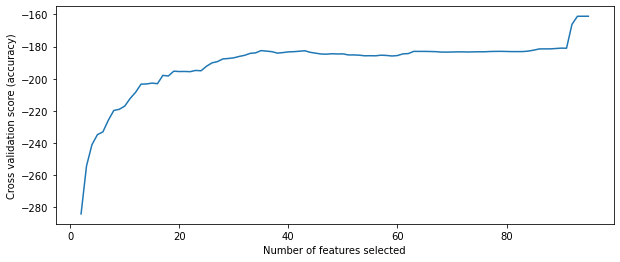

In [6]:
# Label encoder de la cible car RFECV ne fonctionne pas sur des données continues
label_encoder = LabelEncoder()
y_conso = label_encoder.fit_transform(target_emmi_train)

# Test du nombre de features
kfold = KFold(n_splits=3, shuffle=True)

min_features_to_select = 2  # Minimum number of features to consider
rfecv = RFECV(
    estimator=Ridge(),
    step=1,
    cv=kfold,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(data_train,y_conso)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

La RFE nous indique que l'ensemble des features est nécessaire pour obtenir le meilleur score.

### Sur la base d'une RFE pour ElasticNet

Optimal number of features : 85


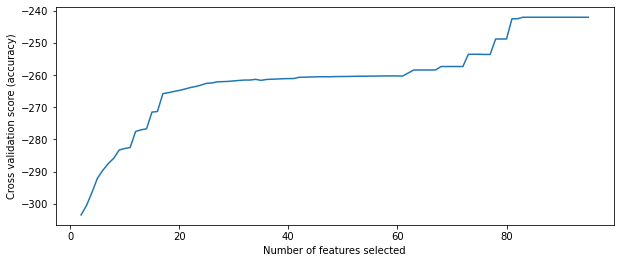

In [7]:
# Test du nombre de features
kfold = KFold(n_splits=3, shuffle=True)

min_features_to_select = 2  # Minimum number of features to consider
rfecv = RFECV(
    estimator=ElasticNet(),
    step=1,
    cv=kfold,
    scoring="neg_mean_absolute_error",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(data_train,y_conso)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [8]:
selected_features_eNet = rfecv.get_support(1)

### Calcul d'un régression linéaire pour comparaison des coefficients

In [9]:
# Calcul d'une regression linéaire pour comparaison des coef linéaires avec ceux de la régularisation (pour les consommations)

model = make_pipeline(StandardScaler(), LinearRegression())
cv_results = cross_validate(model, data_train[features_a_conserver_conso], target_conso_train,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,cv=5,return_estimator=True)

coefs_RL_conso = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs_RL_conso = np.reshape(coefs_RL_conso, (5, data_train[features_a_conserver_conso].shape[1]))
coefs_RL_conso = pd.DataFrame(coefs_RL_conso, columns=data_train[features_a_conserver_conso].columns)
coefs_RL_conso.loc['Abs - mean']=abs(coefs_RL_conso.mean())
coefs_RL_conso=coefs_RL_conso.sort_values(by='Abs - mean',axis=1,ascending=False)

In [10]:
# Calcul d'une regression linéaire pour comparaison des coef linéaires avec ceux de la régularisation (pour les émissions)

model = make_pipeline(StandardScaler(), LinearRegression())
cv_results = cross_validate(model, data_train[features_a_conserver_emmi], target_emmi_train,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,cv=5,return_estimator=True)

coefs_RL_emmi = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs_RL_emmi = np.reshape(coefs_RL_emmi, (5, data_train[features_a_conserver_emmi].shape[1]))
coefs_RL_emmi = pd.DataFrame(coefs_RL_emmi, columns=data_train[features_a_conserver_emmi].columns)
coefs_RL_emmi.loc['Abs - mean']=abs(coefs_RL_emmi.mean())
coefs_RL_emmi=coefs_RL_emmi.sort_values(by='Abs - mean',axis=1,ascending=False)

# Ajout d'une régularisation

## 2) Ridge

### 2-1) Cas des émmissions de CO2

In [11]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))

cv_results = cross_validate(model, data_train, target_emmi_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)

# Récupération des coefs
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5, data_train.shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train.columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)
coefs_ridge_emmi = coefs.iloc[:, : 15]

cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.035888,0.004532,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.294406,0.734522,-303267.101678,-97077.037307,-214.558574,-141.403688
1,0.033875,0.004630,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.616950,0.611207,-233629.193808,-124819.862998,-133.025109,-124.398055
2,0.034613,0.004645,"(StandardScaler(), RidgeCV(alphas=array([1.000...",-0.444320,0.740143,-205353.403848,-113817.785740,-145.683819,-129.286579
3,0.034729,0.004724,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.678218,0.676334,-165273.678815,-111776.697671,-140.790608,-139.545219
4,0.035253,0.004653,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.456606,0.704581,-106159.625015,-125473.825134,-171.181226,-149.733179
Mean,0.034872,0.004637,NaN,0.320372,0.693357,-202736.600633,-114593.041770,-161.047867,-136.873344


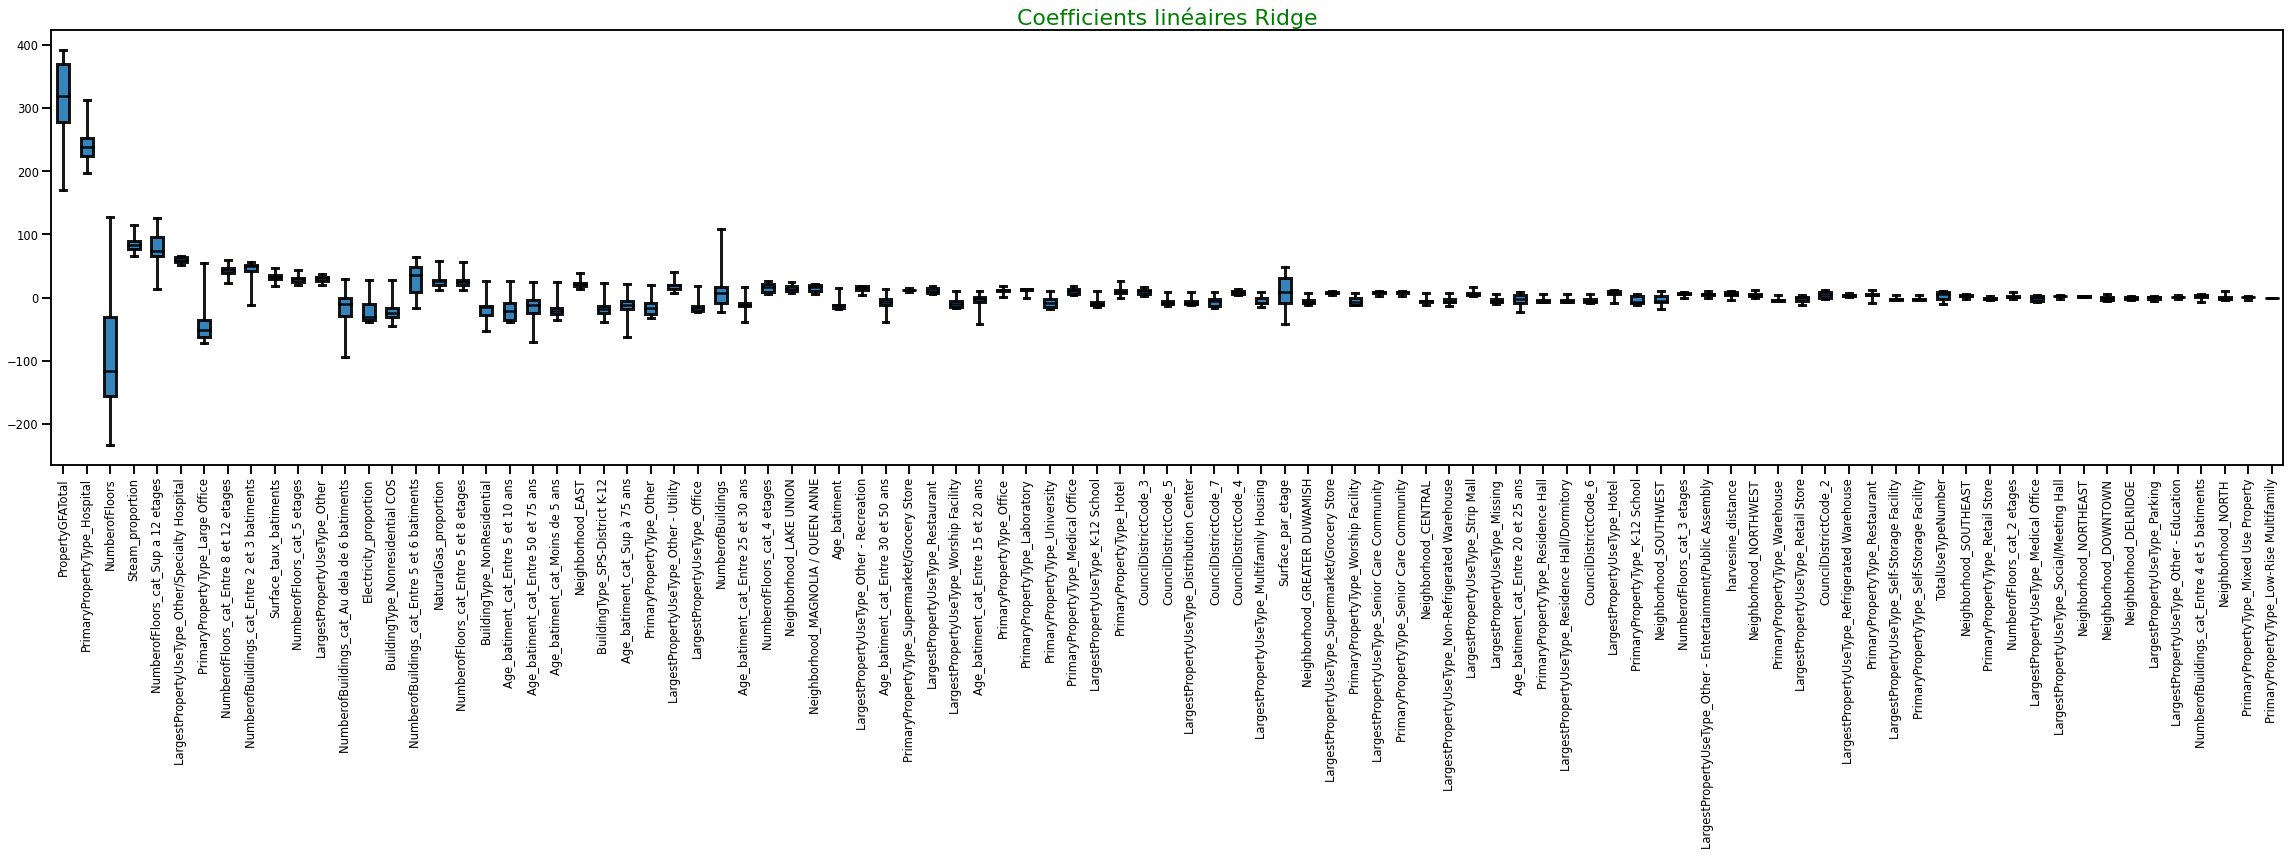

In [12]:
# Récupération des coefficients linéaires

boxplot_property = {
    "vert": True,
    "whis": 100,
    "patch_artist": True,
    "widths": 0.5,
    "rot": 90,
    "boxprops": dict(linewidth=3, color="black", alpha=0.9),
    "medianprops": dict(linewidth=2.5, color="black", alpha=0.9),
    "whiskerprops": dict(linewidth=3, color="black", alpha=0.9),
    "capprops": dict(linewidth=3, color="black", alpha=0.9),
}

sns.set_context("talk",font_scale = 0.7)
# Define the style of the box style
_, ax = plt.subplots(figsize=(40, 8))
_ = coefs.plot.box(**boxplot_property, ax=ax)
_ =ax.set_title('Coefficients linéaires Ridge',fontsize = 22,color='g')

On constate que 7 sur les 10 premièrs coefficients Ridge sont identiques avec la sélection de feature via un stepwise

In [13]:
# Calcul de performance Ridge baseline
model = make_pipeline(StandardScaler(), Ridge())
model.fit(data_train, target_emmi_train)
predictions_emmi_ridge = model.predict(data_test)
print('r2 - test :' , r2_score(target_emmi_test,predictions_emmi_ridge))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_ridge)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_ridge)))

r2 - test : 0.13701466742652435
RMSE - test : 83190.52
MAE - test : 151.29


### Tests d'hyperparamètres

In [14]:
param = {
    'alpha':np.logspace(-5, 5, 200),
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

search = GridSearchCV(Ridge(), param, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')


In [15]:
result = search.fit(data_train, target_emmi_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -132.4219254960778
Best Hyperparameters: {'alpha': 1.3354515629299002, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [16]:
bilan_emmi = []
bilan_conso = []

In [17]:
# Entrainement du modèle
model_Ridge_emmi = make_pipeline(StandardScaler(), Ridge(alpha=1.3354,fit_intercept= True, normalize = True, solver ='auto'))
model_Ridge_emmi.fit(data_train, target_emmi_train)

# Metrics sur les données d'entrainement
predictions_emmi_ridge_train = model_Ridge_emmi.predict(data_train)

print('r2 :', r2_score(target_emmi_train,predictions_emmi_ridge_train))
print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, predictions_emmi_ridge_train)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, predictions_emmi_ridge_train)))

r2 : 0.5253326904568649
RMSE : 179903.94
MAE : 125.67


In [18]:
# Metrics sur les données de test                      
predictions_emmi_ridge_test = model_Ridge_emmi.predict(data_test)

print('r2 - test :' , r2_score(target_emmi_test,predictions_emmi_ridge_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_ridge_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_ridge_test)))

r2 - test : 0.5891722592049315
RMSE - test : 39603.19
MAE - test : 100.45


In [19]:
# Ecriture des résultats
bilan_emmi.append(['Ridge' , 'Train','MAE', format(metrics.mean_absolute_error(target_emmi_train, predictions_emmi_ridge_train))])
bilan_emmi.append(['Ridge' , 'Train','RMSE',  format(metrics.mean_squared_error(target_emmi_train, predictions_emmi_ridge_train))])
bilan_emmi.append(['Ridge' , 'Train', 'R2', r2_score(target_emmi_train, predictions_emmi_ridge_train)])

bilan_emmi.append(['Ridge' ,'Test', 'MAE', format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_ridge_test))])
bilan_emmi.append(['Ridge' , 'Test','RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_ridge_test))])
bilan_emmi.append(['Ridge' , 'Test','R2', r2_score(target_emmi_test,predictions_emmi_ridge_test)])

### Modèle avec une sélection de variables

In [20]:
alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))

cv_results = cross_validate(model, data_train[features_a_conserver_emmi], target_emmi_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.018238,0.004750,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.513530,0.707353,-209086.861191,-107011.905801,-174.731918,-133.398358
1,0.016164,0.004544,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.680312,0.618547,-194983.103150,-122463.430944,-128.963892,-128.600603
2,0.016185,0.004241,"(StandardScaler(), RidgeCV(alphas=array([1.000...",-0.391349,0.732743,-197822.022893,-117058.682139,-145.495283,-131.359117
3,0.016510,0.004475,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.697901,0.654539,-155163.980815,-119303.586071,-136.000316,-142.507626
4,0.016230,0.004258,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.504113,0.684451,-96878.452811,-134023.854873,-153.219296,-149.448797
Mean,0.016665,0.004453,NaN,0.400901,0.679527,-170786.884172,-119972.291965,-147.682141,-137.062900


In [21]:
param = {
    'alpha':np.logspace(-5, 5, 200),
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

search = GridSearchCV(Ridge(), param, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')

result = search.fit(data_train[features_a_conserver_emmi], target_emmi_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -126.34391723619395
Best Hyperparameters: {'alpha': 0.6669919663030128, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [22]:
# Entrainement du modèle
model_emmi_RS = make_pipeline(StandardScaler(), Ridge(alpha=0.6669,fit_intercept= True, normalize = True, solver ='sparse_cg'))
model_emmi_RS.fit(data_train[features_a_conserver_emmi], target_emmi_train)

# Metrics sur les données d'entrainement
predictions_emmi_selec_Ridge_train = model_emmi_RS.predict(data_train[features_a_conserver_emmi])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, predictions_emmi_selec_Ridge_train)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, predictions_emmi_selec_Ridge_train)))
print("R2 : {:.2f}".format(r2_score(target_emmi_train,predictions_emmi_selec_Ridge_train)))



RMSE : 158447.93
MAE : 121.23
R2 : 0.58


In [23]:
# Metrics sur les données de tests
predictions_emmi_selec_Ridge_test = model_emmi_RS.predict(data_test[features_a_conserver_emmi])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_selec_Ridge_test)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_selec_Ridge_test)))
print("R2 : {:.2f}".format(r2_score(target_emmi_test,predictions_emmi_selec_Ridge_test)))


RMSE : 46218.30
MAE : 99.41
R2 : 0.52


In [24]:
bilan_emmi.append(['Ridge_selec' , 'Train','MAE', metrics.mean_absolute_error(target_emmi_train, predictions_emmi_selec_Ridge_train)])
bilan_emmi.append(['Ridge_selec' , 'Train','RMSE', metrics.mean_squared_error(target_emmi_train, predictions_emmi_selec_Ridge_train)])
bilan_emmi.append(['Ridge_selec' , 'Train', 'R2', r2_score(target_emmi_train,predictions_emmi_selec_Ridge_train)])

bilan_emmi.append(['Ridge_selec' , 'Test','MAE', format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_selec_Ridge_test))])
bilan_emmi.append(['Ridge_selec' ,'Test', 'RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_selec_Ridge_test))])
bilan_emmi.append(['Ridge_selec' ,'Test', 'R2', r2_score(target_emmi_test,predictions_emmi_selec_Ridge_test)])

### Modèle avec une log-transformation de la cible

In [25]:
# Entrainement du modèle
model_emmi_ridge_log = make_pipeline(StandardScaler(), Ridge(alpha=1.3354,fit_intercept= True, normalize = True, solver ='auto'))
model_emmi_ridge_log.fit(data_train, target_emmi_log_train)

# Metrics sur les données d'entrainement
predictions_emmi_log_Ridge_train = model_emmi_ridge_log.predict(data_train)

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, np.expm1(predictions_emmi_log_Ridge_train))))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, np.expm1(predictions_emmi_log_Ridge_train))))
print("R2 : {:.2f}".format(r2_score(target_emmi_train,np.expm1(predictions_emmi_log_Ridge_train))))



RMSE : 319752.88
MAE : 120.90
R2 : 0.16


In [26]:
# Metrics sur les données de test
predictions_emmi_log_Ridge_test = model_emmi_ridge_log.predict(data_test)

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, np.expm1(predictions_emmi_log_Ridge_test))))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, np.expm1(predictions_emmi_log_Ridge_test))))
print("R2 : {:.2f}".format(r2_score(target_emmi_test,np.expm1(predictions_emmi_log_Ridge_test))))

RMSE : 69202.47
MAE : 99.24
R2 : 0.28


In [27]:
bilan_emmi.append(['Ridge_log' , 'Train','MAE', format(metrics.mean_absolute_error(target_emmi_train, np.expm1(predictions_emmi_log_Ridge_train)))])
bilan_emmi.append(['Ridge_log' , 'Train','RMSE', format(metrics.mean_squared_error(target_emmi_train, np.expm1(predictions_emmi_log_Ridge_train)))])
bilan_emmi.append(['Ridge_log' , 'Train', 'R2', format(r2_score(target_emmi_train,np.expm1(predictions_emmi_log_Ridge_train)))])

bilan_emmi.append(['Ridge_log' , 'Test','MAE', format(metrics.mean_absolute_error(target_emmi_test, np.expm1(predictions_emmi_log_Ridge_test)))])
bilan_emmi.append(['Ridge_log' ,'Test', 'RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_log_Ridge_test))])
bilan_emmi.append(['Ridge_log' ,'Test', 'R2', r2_score(target_emmi_test,np.expm1(predictions_emmi_log_Ridge_test))])

## 2-2) Consommation

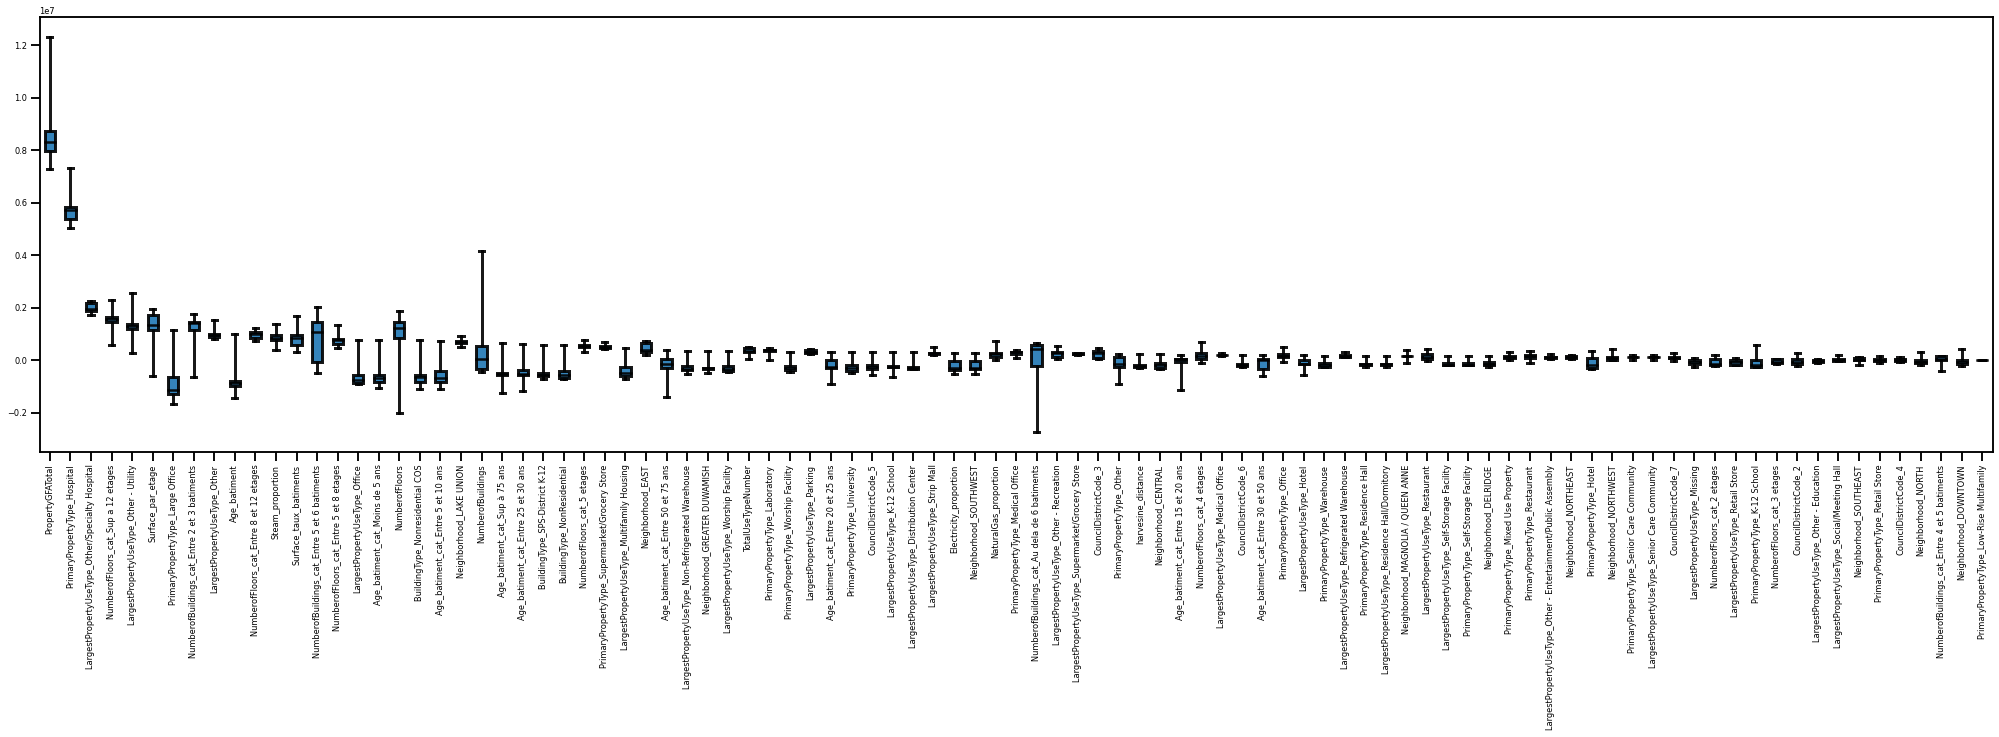

In [28]:
from sklearn.linear_model import RidgeCV

alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))

cv_results = cross_validate(model, data_train, target_conso_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5, data_train.shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train.columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)
coefs_ridge_conso = coefs.iloc[:, : 15]

sns.set_context("talk",font_scale = 0.5)
# Define the style of the box style
_, ax = plt.subplots(figsize=(35, 8))
_ = coefs.plot.box(**boxplot_property, ax=ax)

On constate que 7 sur les 10 premièrs coefficients Ridge sont identiques avec la sélection de feature via un stepwise

In [29]:
cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.034072,0.004739,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.291662,0.675770,-3.726016e+14,-1.229884e+14,-7.357278e+06,-4.370294e+06
1,0.033423,0.005569,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.490239,0.685049,-3.621092e+14,-1.051808e+14,-4.989080e+06,-4.056146e+06
2,0.034838,0.004143,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.017102,0.684755,-1.643288e+14,-1.480878e+14,-4.891140e+06,-4.410043e+06
3,0.036410,0.004596,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.685659,0.617610,-1.298232e+14,-1.561627e+14,-3.972918e+06,-4.701328e+06
4,0.035553,0.004180,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.668696,0.643914,-7.394810e+13,-1.623672e+14,-4.664081e+06,-4.790991e+06


### Tests d'hyperparamètres

In [30]:
param = {
    'alpha':np.logspace(-5, 5, 200),
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

search = GridSearchCV(Ridge(), param, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')


In [31]:
result = search.fit(data_train, target_conso_train)
print('Best Hyperparameters: %s' % result.best_params_)

Best Hyperparameters: {'alpha': 0.6669919663030128, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [32]:
# Entrainement du modèle
model_Ridge_conso = make_pipeline(StandardScaler(), Ridge(alpha=1,fit_intercept= True, normalize = True, solver ='sag'))
model_Ridge_conso.fit(data_train, target_conso_train)

# Metrics sur les données d'entrainement
predictions_conso_Ridge_train = model_Ridge_conso.predict(data_train)

print('r2 - train :', r2_score(target_conso_train,predictions_conso_Ridge_train))
print("RMSE - train : {:.2f}".format(metrics.mean_squared_error(target_conso_train, predictions_conso_Ridge_train)))
print("MAE - train : {:.2f}".format(metrics.mean_absolute_error(target_conso_train, predictions_conso_Ridge_train)))

r2 - train : 0.5613756939777259
RMSE - train : 179652813785788.72
MAE - train : 4537684.96


In [33]:
# Metrics sur les données de test
predictions_conso_Ridge_test = model_Ridge_conso.predict(data_test)

print('r2 - test :', r2_score(target_conso_test,predictions_conso_Ridge_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_conso_test, predictions_conso_Ridge_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_conso_test, predictions_conso_Ridge_test)))

r2 - test : 0.6937013019813816
RMSE - test : 47140852214066.91
MAE - test : 3844164.96


In [34]:

bilan_conso.append(['Ridge' , 'Train','MAE', metrics.mean_absolute_error(target_conso_train, predictions_conso_Ridge_train)])
bilan_conso.append(['Ridge' , 'Train','RMSE', metrics.mean_squared_error(target_conso_train, predictions_conso_Ridge_train)])
bilan_conso.append(['Ridge' , 'Train', 'R2', r2_score(target_conso_train,predictions_conso_Ridge_train)])

bilan_conso.append(['Ridge' , 'Test', 'MAE', metrics.mean_absolute_error(target_conso_test, predictions_conso_Ridge_test)])
bilan_conso.append(['Ridge' , 'Test','RMSE', metrics.mean_squared_error(target_conso_test, predictions_conso_Ridge_test)])
bilan_conso.append(['Ridge' , 'Test','R2', r2_score(target_conso_test,predictions_conso_Ridge_test)])

### Modèle avec une sélection de variables

In [35]:
alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))

cv_results = cross_validate(model, data_train[features_a_conserver_conso], target_conso_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
cv_results.loc['Mean'] = cv_results.mean()
cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.015972,0.003819,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.617430,0.637348,-2.012404e+14,-1.375632e+14,-5.514644e+06,-3.850608e+06
1,0.011150,0.003340,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.507743,0.679056,-3.496750e+14,-1.071825e+14,-4.663323e+06,-3.931565e+06
2,0.011448,0.003385,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.059533,0.673129,-1.572349e+14,-1.535490e+14,-4.547207e+06,-4.113101e+06
3,0.011011,0.003414,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.740072,0.602198,-1.073505e+14,-1.624564e+14,-3.173589e+06,-4.434733e+06
4,0.011009,0.003339,"(StandardScaler(), RidgeCV(alphas=array([1.000...",0.717267,0.626869,-6.310686e+13,-1.701394e+14,-3.813979e+06,-4.430795e+06
Mean,0.012118,0.003459,NaN,0.528409,0.643720,-1.757215e+14,-1.461781e+14,-4.342548e+06,-4.152160e+06


In [36]:
param = {
    'alpha':np.logspace(-5, 5, 200),
    'fit_intercept':[True,False],
    'normalize':[True,False],
'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

search = GridSearchCV(Ridge(), param, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')

result = search.fit(data_train[features_a_conserver_conso], target_conso_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -4317723.817075832
Best Hyperparameters: {'alpha': 0.10473708979594508, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [37]:
# Entrainement du modèle
model_Ridge_select_conso = make_pipeline(StandardScaler(), Ridge(alpha=4.2475,fit_intercept= True, normalize = False, solver ='svd'))
model_Ridge_select_conso.fit(data_train[features_a_conserver_conso], target_conso_train)

# Metrics sur les données d'entrainement
predictions_conso_selec_Ridge_train = model_Ridge_select_conso.predict(data_train[features_a_conserver_conso])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_conso_train, predictions_conso_selec_Ridge_train)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_conso_train, predictions_conso_selec_Ridge_train)))
print("R2 : {:.2f}".format(r2_score(target_conso_train,predictions_conso_selec_Ridge_train)))

RMSE : 147548914174955.59
MAE : 4219546.31
R2 : 0.64


In [38]:
# Metrics sur les données de tests
predictions_conso_selec_Ridge_test = model_Ridge_select_conso.predict(data_test[features_a_conserver_conso])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_conso_test, predictions_conso_selec_Ridge_test)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_conso_test, predictions_conso_selec_Ridge_test)))
print("R2 : {:.2f}".format(r2_score(target_conso_test,predictions_conso_selec_Ridge_test)))

RMSE : 68951026245069.36
MAE : 3962714.46
R2 : 0.55


In [39]:
#  Ecriture des résultats
bilan_conso.append(['Ridge_selec' , 'Train','MAE', metrics.mean_absolute_error(target_conso_train, predictions_conso_selec_Ridge_train)])
bilan_conso.append(['Ridge_selec' , 'Train','RMSE', metrics.mean_squared_error(target_conso_train, predictions_conso_selec_Ridge_train)])
bilan_conso.append(['Ridge_selec' , 'Train', 'R2', r2_score(target_conso_train,predictions_conso_selec_Ridge_train)])

bilan_conso.append(['Ridge_selec' , 'Test','MAE', format(metrics.mean_absolute_error(target_conso_test, predictions_conso_selec_Ridge_test))])
bilan_conso.append(['Ridge_selec' ,'Test', 'RMSE', format(metrics.mean_squared_error(target_conso_test, predictions_conso_selec_Ridge_test))])
bilan_conso.append(['Ridge_selec' ,'Test', 'R2', r2_score(target_conso_test,predictions_conso_selec_Ridge_test)])

### Modèle avec une log-transformation de la cible

In [40]:
# Entrainement du modèle
model_Ridge_conso_log = make_pipeline(StandardScaler(), Ridge(alpha=1.3354,fit_intercept= True, normalize = True, solver ='auto'))
model_Ridge_conso_log.fit(data_train, target_conso_log_train)

# Metrics sur les données d'entrainement
predictions_conso_log_Ridge_train = model_Ridge_conso_log.predict(data_train)

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, np.expm1(predictions_conso_log_Ridge_train))))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, np.expm1(predictions_conso_log_Ridge_train))))
print("R2 : {:.2f}".format(r2_score(target_emmi_train,np.expm1(predictions_conso_log_Ridge_train))))



RMSE : 259472048968069.56
MAE : 4637476.73
R2 : -684603671.66


In [41]:
# Metrics sur les données de test
predictions_conso_log_Ridge_test = model_Ridge_conso_log.predict(data_test)

print("RMSE : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, np.expm1(predictions_conso_log_Ridge_test))))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, np.expm1(predictions_conso_log_Ridge_test))))
print("R2 : {:.2f}".format(r2_score(target_emmi_test,np.expm1(predictions_conso_log_Ridge_test))))

RMSE : 63857756398525.09
MAE : 4364017.72
R2 : -662434905.22


In [42]:
bilan_conso.append(['Ridge_log' , 'Train','MAE', format(metrics.mean_absolute_error(target_emmi_train, np.expm1(predictions_conso_log_Ridge_train)))])
bilan_conso.append(['Ridge_log' , 'Train','RMSE', format(metrics.mean_squared_error(target_emmi_train, np.expm1(predictions_conso_log_Ridge_train)))])
bilan_conso.append(['Ridge_log' , 'Train', 'R2', format(r2_score(target_emmi_train,np.expm1(predictions_conso_log_Ridge_train)))])

bilan_conso.append(['Ridge_log' , 'Test','MAE', format(metrics.mean_absolute_error(target_emmi_test, np.expm1(predictions_conso_log_Ridge_test)))])
bilan_conso.append(['Ridge_log' ,'Test', 'RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_conso_log_Ridge_test))])
bilan_conso.append(['Ridge_log' ,'Test', 'R2', r2_score(target_emmi_test,np.expm1(predictions_conso_log_Ridge_test))])

## 3) ElasticNet
### 3-1) Cas de la consommation

In [43]:
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas))

cv_results = cross_validate(model, data_train, target_conso_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5, data_train.shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train.columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)

cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.145427,0.004481,"(StandardScaler(), ElasticNetCV(alphas=array([...",-0.045623,0.676675,-5.500206e+14,-1.226455e+14,-7.808410e+06,-4.437228e+06
1,0.094395,0.004014,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.225844,0.355516,-5.499219e+14,-2.152317e+14,-6.634357e+06,-5.741421e+06
2,0.129685,0.004184,"(StandardScaler(), ElasticNetCV(alphas=array([...",-0.028283,0.701844,-1.719166e+14,-1.400602e+14,-5.326574e+06,-4.635205e+06
3,0.089453,0.003963,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.299510,0.327541,-2.893030e+14,-2.746225e+14,-5.409175e+06,-6.223943e+06
4,0.088986,0.003958,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.516947,0.336504,-1.078191e+14,-3.025395e+14,-5.501234e+06,-5.962963e+06


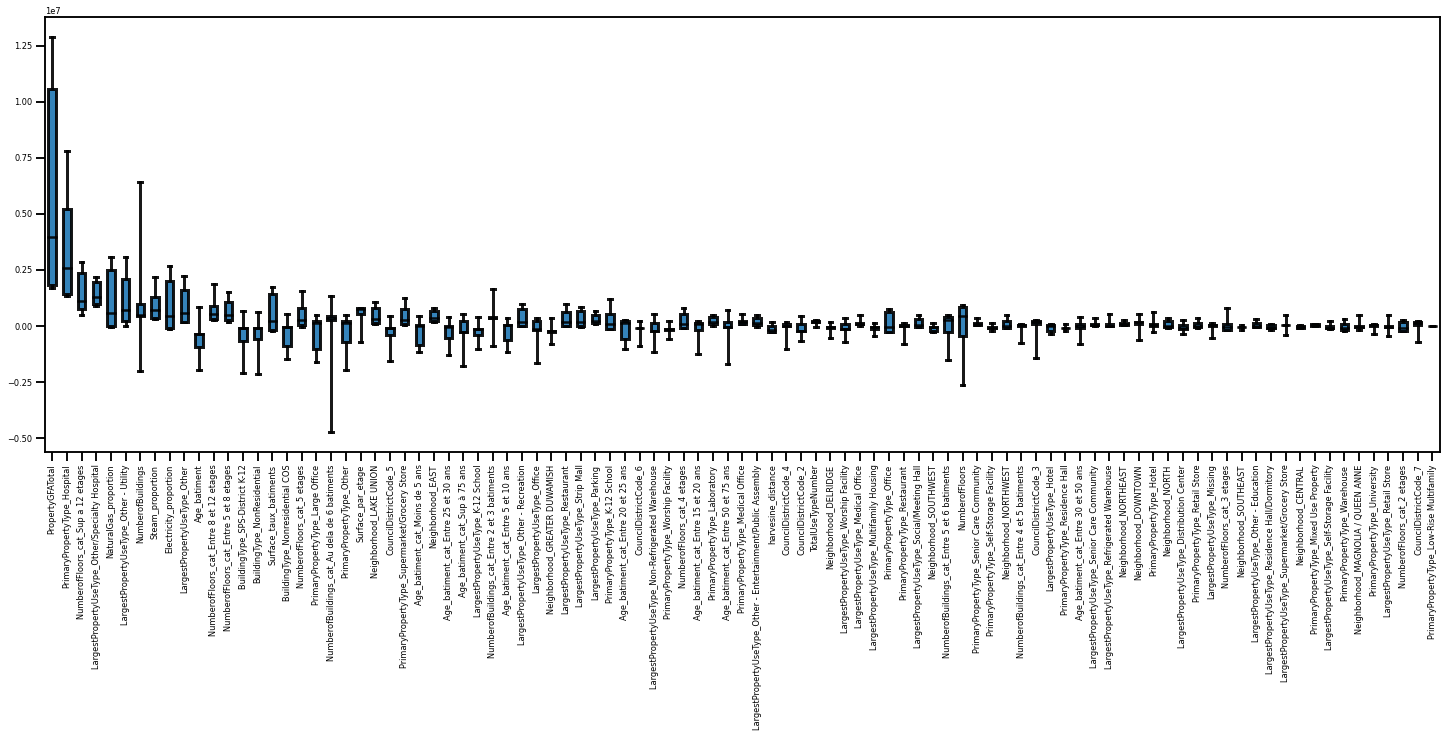

In [44]:
# Visualisation des coefficients 

sns.set_context("talk",font_scale = 0.5)
# Define the style of the box style
_, ax = plt.subplots(figsize=(25, 8))
_ = coefs.plot.box(**boxplot_property, ax=ax)

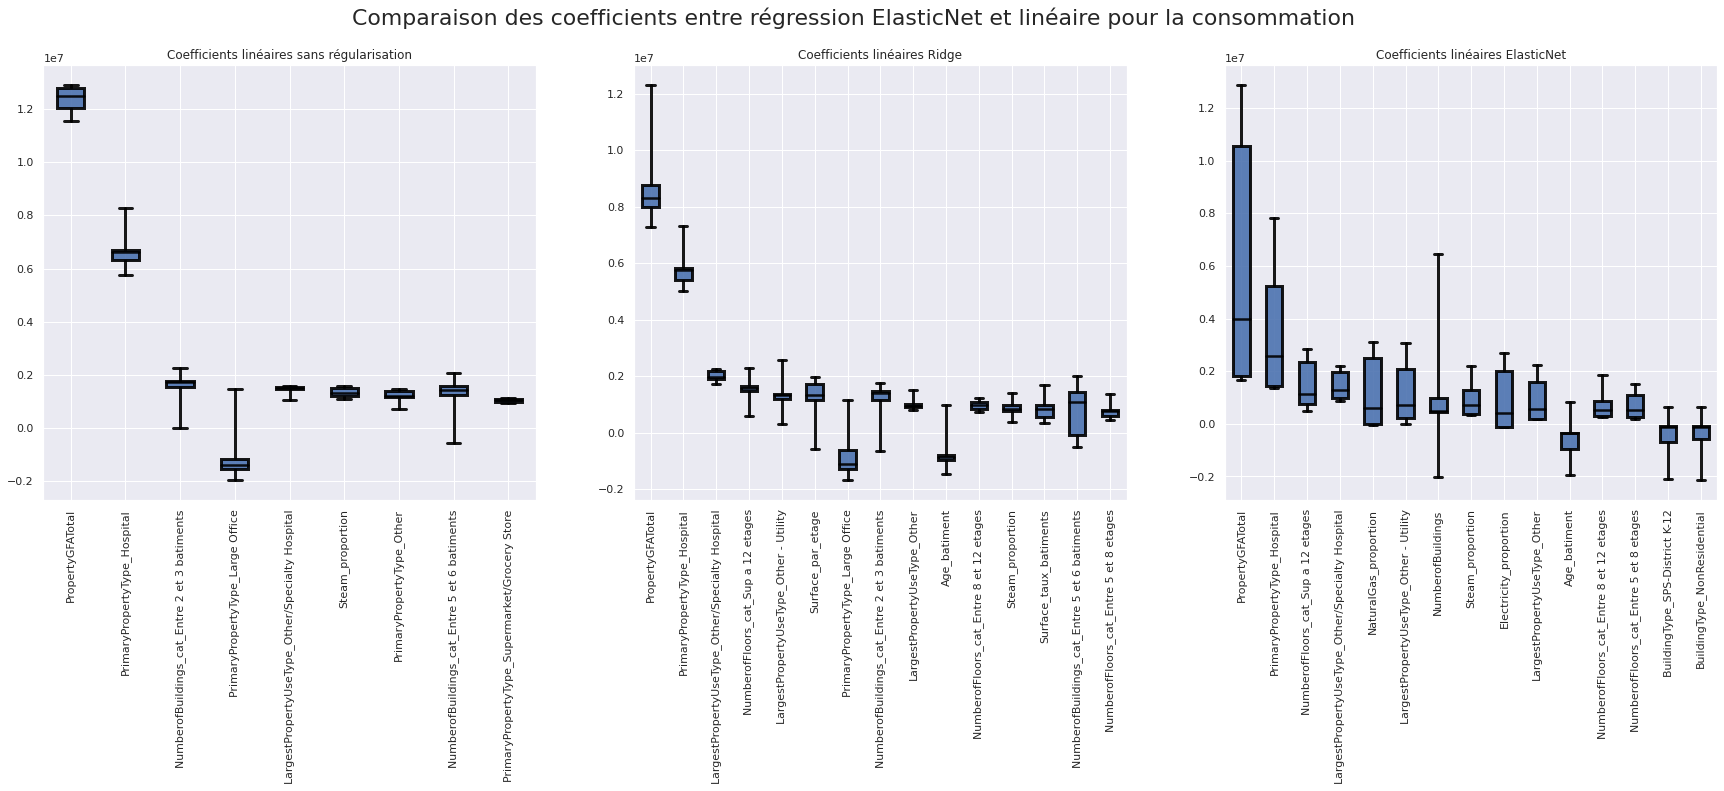

In [45]:
# Visualisation des coefficients entre régression linéaire et Ridge

coefs_elas_conso = coefs.iloc[:, : 15]
sns.set(font_scale = 1)
# Define the style of the box style
_, ax = plt.subplots(1,3,figsize=(30, 8))
_ = coefs_elas_conso.plot.box(**boxplot_property, ax=ax[2])
_ = coefs_RL_conso.plot.box(**boxplot_property, ax=ax[0])
_ = coefs_ridge_conso.plot.box(**boxplot_property, ax=ax[1])

_ = ax[2].set_title('Coefficients linéaires ElasticNet')
_ = ax[1].set_title('Coefficients linéaires Ridge')
_ = ax[0].set_title('Coefficients linéaires sans régularisation')

_=plt.suptitle('Comparaison des coefficients entre régression ElasticNet et linéaire pour la consommation', fontsize=22)

### Tests d'hyperparamètres

In [46]:
from sklearn.linear_model import ElasticNet
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-5, 5, 200),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

search = GridSearchCV(ElasticNet(), param_eNet, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')


In [47]:
result = search.fit(data_train, target_conso_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % result.best_score_)

Best Hyperparameters: {'alpha': 100000.0, 'l1_ratio': 1.0, 'max_iter': 10}
Best Score: -4617312.570334172


In [48]:
# Entrainement du modèle
model_EN_conso = ElasticNet(alpha=1,l1_ratio=0.6,max_iter=10)
model_EN_conso.fit(data_train, target_conso_train)

# Metrics sur les données d'entrainement
predictions_conso_eNet_train = model_EN_conso.predict(data_train)

print('r2 - test :', r2_score(target_conso_train,predictions_conso_eNet_train))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_conso_train, predictions_conso_eNet_train)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_conso_train, predictions_conso_eNet_train)))

r2 - test : 0.5103229952887327
RMSE - test : 200563102716220.03
MAE - test : 4692376.54


In [49]:
# Metrics sur les données de test
predictions_conso_eNet_test = model_EN_conso.predict(data_test)

print('r2 - test :', r2_score(target_conso_test,predictions_conso_eNet_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_conso_test, predictions_conso_eNet_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_conso_test, predictions_conso_eNet_test)))

r2 - test : 0.2674857536792383
RMSE - test : 112737488124767.17
MAE - test : 4889924.36


In [50]:
# Ecriture des résultats
bilan_conso.append(['ElasticNet' , 'Train','MAE', metrics.mean_absolute_error(target_conso_train, predictions_conso_eNet_train)])
bilan_conso.append(['ElasticNet' , 'Train','RMSE', metrics.mean_squared_error(target_conso_train, predictions_conso_eNet_train)])
bilan_conso.append(['ElasticNet' , 'Train', 'R2', r2_score(target_conso_train,predictions_conso_eNet_train)])

bilan_conso.append(['ElasticNet' , 'Test', 'MAE', format(metrics.mean_absolute_error(target_conso_test, predictions_conso_eNet_test))])
bilan_conso.append(['ElasticNet' , 'Test','RMSE', format(metrics.mean_squared_error(target_conso_test, predictions_conso_eNet_test))])
bilan_conso.append(['ElasticNet' , 'Test','R2', r2_score(target_conso_test,predictions_conso_eNet_test)])

### Avec une sélection de variables

In [51]:
alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas))

cv_results = cross_validate(model, data_train[features_a_conserver_conso], target_conso_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5, data_train[features_a_conserver_conso].shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train[features_a_conserver_conso].columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)

cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.058575,0.004539,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.613123,0.638928,-2.035058e+14,-1.369639e+14,-5.634426e+06,-3.927346e+06
1,0.054871,0.004529,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.531970,0.686161,-3.324652e+14,-1.048097e+14,-4.541241e+06,-3.917580e+06
2,0.053117,0.003589,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.018493,0.674658,-1.640962e+14,-1.528308e+14,-4.629877e+06,-4.142943e+06
3,0.043924,0.003991,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.757138,0.604263,-1.003024e+14,-1.616134e+14,-3.152931e+06,-4.489341e+06
4,0.044854,0.003815,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.666248,0.630094,-7.449454e+13,-1.686688e+14,-4.053023e+06,-4.538922e+06


In [52]:
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-5, 5, 200),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

search = GridSearchCV(ElasticNet(), param_eNet, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')
result = search.fit(data_train[features_a_conserver_conso], target_conso_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % result.best_score_)

Best Hyperparameters: {'alpha': 39626.88638701478, 'l1_ratio': 1.0, 'max_iter': 10}
Best Score: -4364436.962446125


In [53]:
# Entrainement du modèle
model_EN_conso_select = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1,l1_ratio=0.6,max_iter=10))
model_EN_conso_select.fit(data_train[features_a_conserver_conso], target_conso_train)

# Metrics sur les données d'entrainement
predictions_conso_select_eNet_train = model_EN_conso_select.predict(data_train[features_a_conserver_conso])

print('r2 - test :', r2_score(target_conso_train,predictions_conso_select_eNet_train))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_conso_train, predictions_conso_select_eNet_train)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_conso_train, predictions_conso_select_eNet_train)))

r2 - test : 0.6389632462712549
RMSE - test : 147874314753916.44
MAE - test : 4180927.34


In [55]:
# Metrics sur les données de test
predictions_conso_select_eNet_test = model_EN_conso_select.predict(data_test[features_a_conserver_conso])

print('r2 - test :', r2_score(target_conso_test,predictions_conso_select_eNet_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_conso_test, predictions_conso_select_eNet_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_conso_test, predictions_conso_select_eNet_test)))

r2 - test : 0.5799276743863446
RMSE - test : 64651164203672.27
MAE - test : 3861166.19


In [56]:
# Ecriture des résultats
bilan_conso.append(['ElasticNet - select' , 'Train','MAE', metrics.mean_absolute_error(target_conso_train, predictions_conso_select_eNet_train)])
bilan_conso.append(['ElasticNet - select' , 'Train','RMSE', metrics.mean_squared_error(target_conso_train, predictions_conso_select_eNet_train)])
bilan_conso.append(['ElasticNet - select' , 'Train', 'R2', r2_score(target_conso_train,predictions_conso_select_eNet_train)])

bilan_conso.append(['ElasticNet - select' , 'Test', 'MAE', format(metrics.mean_absolute_error(target_conso_test, predictions_conso_select_eNet_test))])
bilan_conso.append(['ElasticNet - select' , 'Test','RMSE', format(metrics.mean_squared_error(target_conso_test, predictions_conso_select_eNet_test))])
bilan_conso.append(['ElasticNet - select' , 'Test','R2', r2_score(target_conso_test,predictions_conso_select_eNet_test)])

### 3-2) Cas des émissions de CO2

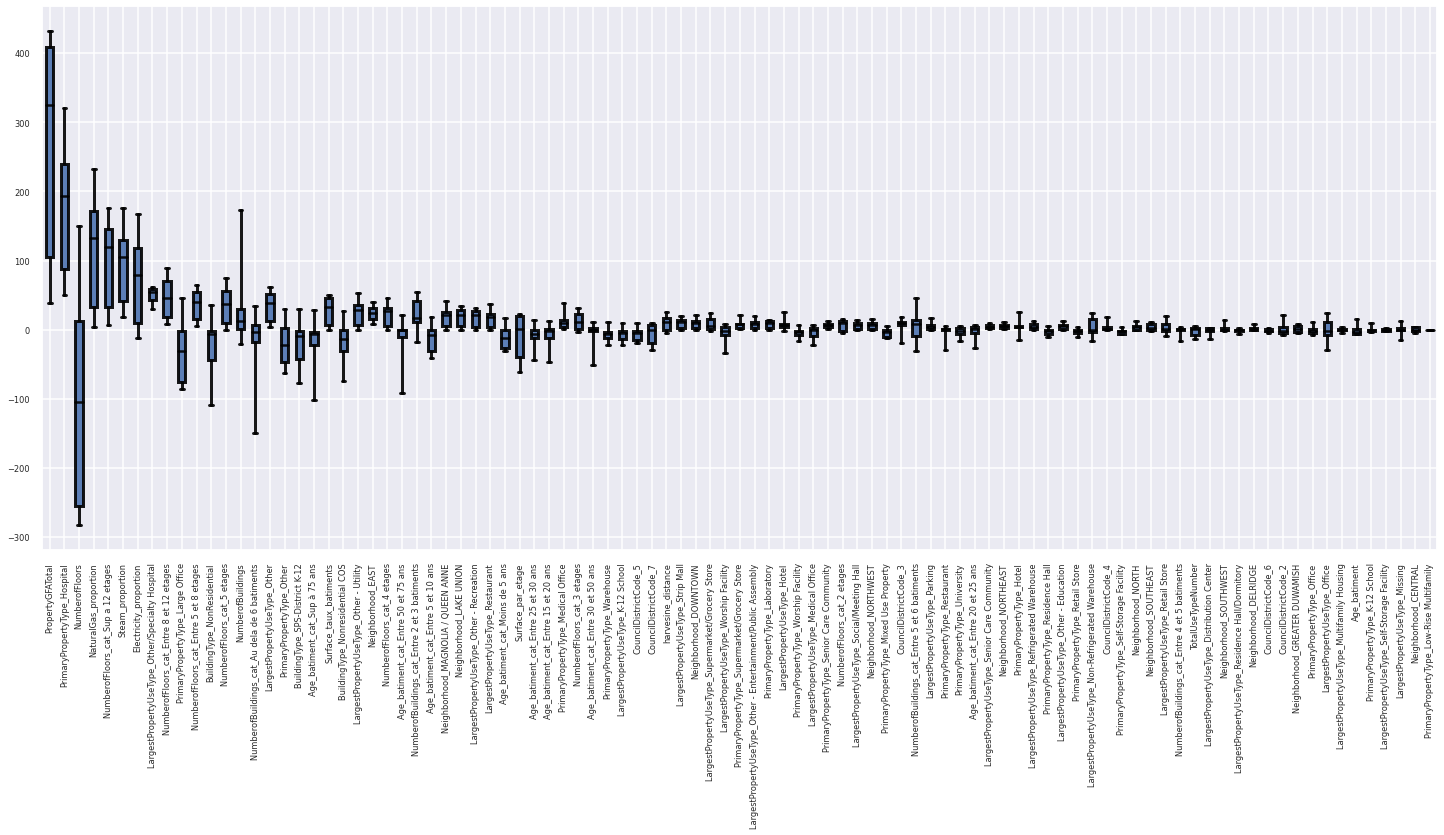

In [57]:

alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas))

cv_results = cross_validate(model, data_train, target_emmi_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5, data_train.shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train.columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)

cv_results

sns.set_context("talk",font_scale = 0.5)
# Define the style of the box style
_, ax = plt.subplots(figsize=(25, 10))
_ = coefs.plot.box(**boxplot_property, ax=ax)

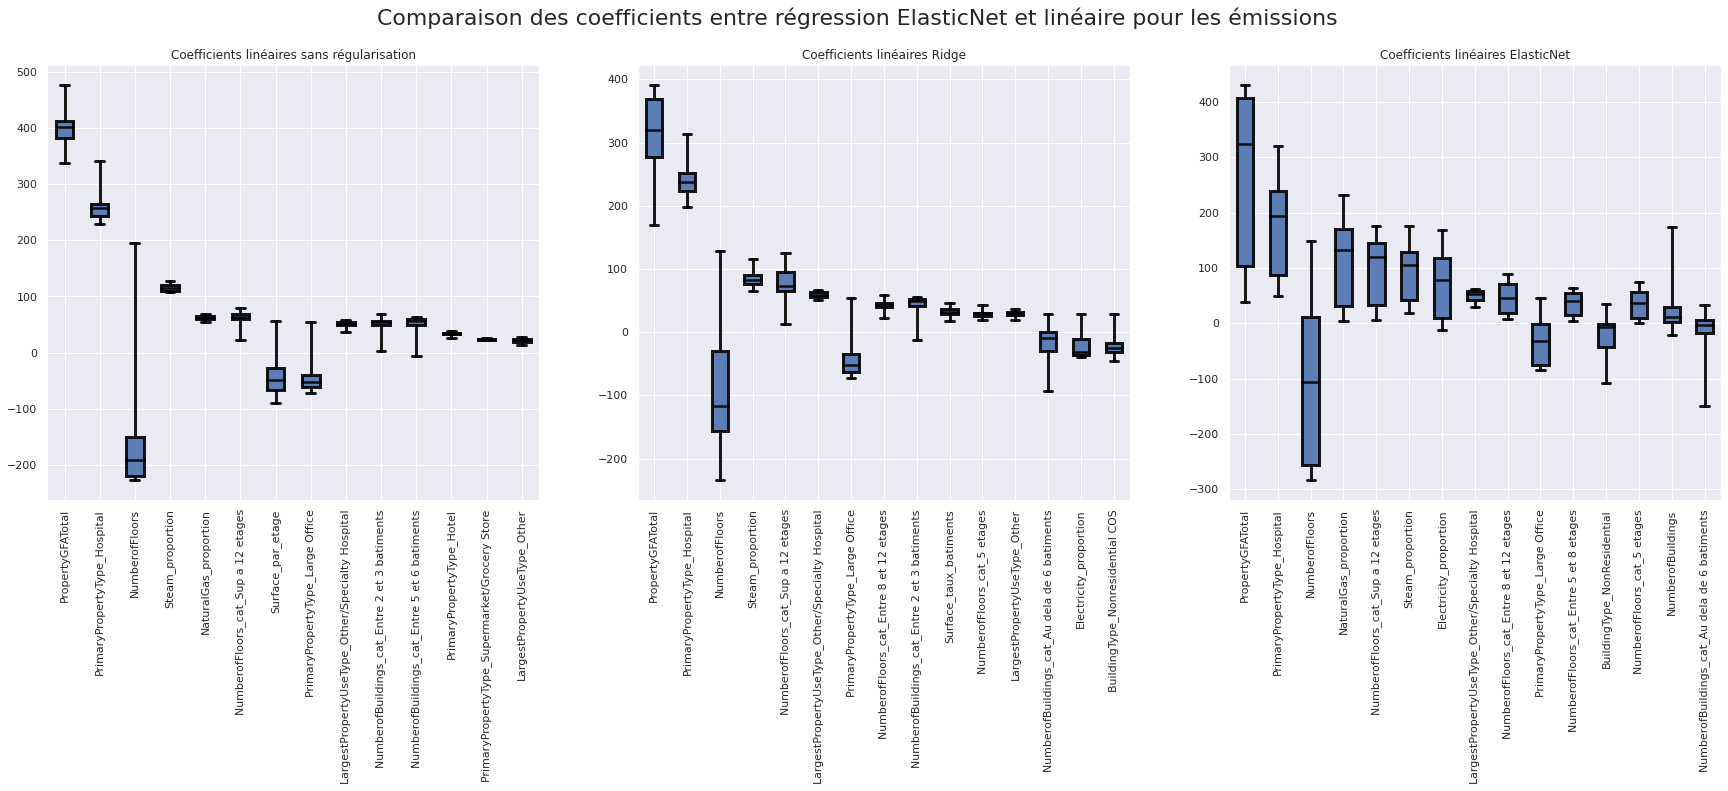

In [58]:
# Visualisation des coefficients entre régression linéaire et ElasticNet

coefs_elas_emmi = coefs.iloc[:, : 15]
sns.set(font_scale = 1)
# Define the style of the box style
_, ax = plt.subplots(1,3,figsize=(30, 8))
_ = coefs_elas_emmi.plot.box(**boxplot_property, ax=ax[2])
_ = coefs_RL_emmi.plot.box(**boxplot_property, ax=ax[0])
_ = coefs_ridge_emmi.plot.box(**boxplot_property, ax=ax[1])

_ = ax[2].set_title('Coefficients linéaires ElasticNet')
_ = ax[0].set_title('Coefficients linéaires sans régularisation')
_ = ax[1].set_title('Coefficients linéaires Ridge')

_=plt.suptitle('Comparaison des coefficients entre régression ElasticNet et linéaire pour les émissions', fontsize=22)

### Tests d'hyperparamètres

In [59]:
from sklearn.linear_model import ElasticNet
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-5, 5, 200),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

search = GridSearchCV(ElasticNet(), param_eNet, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')


In [60]:
result = search.fit(data_train, target_emmi_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % result.best_score_)

Best Hyperparameters: {'alpha': 3.7834626171319328, 'l1_ratio': 1.0, 'max_iter': 10}
Best Score: -147.61822394909086


In [61]:
# Entrainement du modèle
model_EN_emmi = make_pipeline(StandardScaler(), ElasticNet(alpha=1,l1_ratio=1,max_iter=10))
model_EN_emmi.fit(data_train, target_emmi_train)

# Metrics sur les données d'entrainement
predictions_emmi_eNet_train = model_EN_emmi.predict(data_train)
print('r2 - test :', r2_score(target_emmi_train,predictions_emmi_eNet_train))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, predictions_emmi_eNet_train)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, predictions_emmi_eNet_train)))

r2 - test : 0.6895045233571957
RMSE - test : 117681.08
MAE - test : 140.56


In [62]:
# Metrics sur les données de test
predictions_emmi_eNet_test = model_EN_emmi.predict(data_test)

print('r2 - test :', r2_score(target_emmi_test,predictions_emmi_eNet_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_eNet_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_eNet_test)))

r2 - test : 0.17254368960140198
RMSE - test : 79765.58
MAE - test : 139.76


In [63]:
# Ecriture des résultats
bilan_emmi.append(['ElasticNet' , 'Train','MAE', metrics.mean_absolute_error(target_emmi_train, predictions_emmi_eNet_train)])
bilan_emmi.append(['ElasticNet' , 'Train','RMSE', metrics.mean_squared_error(target_emmi_train, predictions_emmi_eNet_train)])
bilan_emmi.append(['ElasticNet' , 'Train', 'R2', r2_score(target_emmi_train,predictions_emmi_eNet_train)])

bilan_emmi.append(['ElasticNet' , 'Test', 'MAE', format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_eNet_test))])
bilan_emmi.append(['ElasticNet' , 'Test','RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_eNet_test))])
bilan_emmi.append(['ElasticNet' , 'Test','R2', r2_score(target_emmi_test, predictions_emmi_eNet_test)])

### Avec une sélection de variables

In [64]:
alphas = np.arange(0.001, 1000, 10)
model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas))

cv_results = cross_validate(model, data_train[features_a_conserver_conso], target_emmi_train, cv=5,scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),return_train_score=True,return_estimator=True)
cv_results=pd.DataFrame(cv_results)
coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = np.reshape(coefs, (5,data_train[features_a_conserver_conso].shape[1]))
coefs = pd.DataFrame(coefs, columns=data_train[features_a_conserver_conso].columns)
coefs.loc['Abs - mean']=abs(coefs.mean())
coefs=coefs.sort_values(by='Abs - mean',axis=1,ascending=False)

cv_results

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.054326,0.004161,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.484281,0.674009,-221658.356071,-119204.636764,-168.370893,-127.060356
1,0.051795,0.004244,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.701703,0.593222,-181936.458927,-130593.659497,-126.489428,-128.624492
2,0.051594,0.004097,"(StandardScaler(), ElasticNetCV(alphas=array([...",-0.561880,0.711901,-222068.117012,-126187.699756,-149.895144,-128.737402
3,0.052129,0.004299,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.693410,0.613236,-157470.610272,-133567.545807,-115.551445,-136.493182
4,0.051640,0.004037,"(StandardScaler(), ElasticNetCV(alphas=array([...",0.472118,0.651768,-103128.974140,-147905.004592,-142.554068,-145.033027


In [65]:
param_eNet = {"max_iter": [10, 100, 1000],
              "alpha": np.logspace(-5, 5, 200),
              "l1_ratio": np.arange(0.0, 1.1, 0.1)}

search = GridSearchCV(ElasticNet(), param_eNet, scoring=(['r2','neg_mean_squared_error','neg_mean_absolute_error']),cv=5,refit = 'neg_mean_absolute_error')
result = search.fit(data_train[features_a_conserver_conso], target_emmi_train)
print('Best Hyperparameters: %s' % result.best_params_)
print('Best Score: %s' % result.best_score_)

Best Hyperparameters: {'alpha': 1.6831803533309584, 'l1_ratio': 1.0, 'max_iter': 10}
Best Score: -139.3038228598092


In [66]:
# Entrainement du modèle
model_EN_select_emmi = make_pipeline(StandardScaler(), ElasticNet(alpha=1,l1_ratio=1,max_iter=10))
model_EN_select_emmi.fit(data_train[features_a_conserver_conso], target_emmi_train)

# Metrics sur les données d'entrainement
predictions_emmi_select_eNet_train = model_EN_select_emmi.predict(data_train[features_a_conserver_conso])

print('r2 - test :', r2_score(target_emmi_train,predictions_emmi_select_eNet_train))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_train, predictions_emmi_select_eNet_train)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_train, predictions_emmi_select_eNet_train)))

r2 - test : 0.6421400483901485
RMSE - test : 135632.72
MAE - test : 133.38


In [68]:
# Metrics sur les données de test
predictions_emmi_select_eNet_test = model_EN_select_emmi.predict(data_test[features_a_conserver_conso])

print('r2 - test :', r2_score(target_emmi_test,predictions_emmi_select_eNet_test))
print("RMSE - test : {:.2f}".format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_select_eNet_test)))
print("MAE - test : {:.2f}".format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_select_eNet_test)))

r2 - test : 0.14902499971465122
RMSE - test : 82032.75
MAE - test : 127.31


In [69]:
bilan_emmi.append(['ElasticNet - select' , 'Train','MAE', metrics.mean_absolute_error(target_emmi_train, predictions_emmi_select_eNet_train)])
bilan_emmi.append(['ElasticNet - select' , 'Train','RMSE', metrics.mean_squared_error(target_emmi_train, predictions_emmi_select_eNet_train)])
bilan_emmi.append(['ElasticNet - select' , 'Train', 'R2', r2_score(target_emmi_train,predictions_emmi_select_eNet_train)])

bilan_emmi.append(['ElasticNet - select' , 'Test', 'MAE', format(metrics.mean_absolute_error(target_emmi_test, predictions_emmi_select_eNet_test))])
bilan_emmi.append(['ElasticNet - select' , 'Test','RMSE', format(metrics.mean_squared_error(target_emmi_test, predictions_emmi_select_eNet_test))])
bilan_emmi.append(['ElasticNet - select' , 'Test','R2', r2_score(target_emmi_test, predictions_emmi_select_eNet_test)])

# 4) Analyse des modèles linéaires

In [70]:
# Importation des résultats précédents

bilan_conso_lineaire = pd.read_csv('bilan_conso.csv', sep=",")
bilan_emmi_lineaire = pd.read_csv('bilan_emmi.csv', sep=",")
predictions_bilan_lineaire = pd.read_csv('predictions_bilan.csv',sep=',')

In [71]:
# Ajout des résultats actuels
bilan_conso =pd.DataFrame(bilan_conso)
bilan_conso_lineaire.reset_index(drop=True,inplace=True)
bilan_conso_lineaire.columns = ['0','1','2','3']
bilan_conso.reset_index(drop=True,inplace=True)
bilan_conso.columns = ['0','1','2','3']

bilan_emmi =pd.DataFrame(bilan_emmi)
bilan_emmi_lineaire.reset_index(drop=True,inplace=True)
bilan_emmi_lineaire.columns = ['0','1','2','3']
bilan_emmi.reset_index(drop=True,inplace=True)
bilan_emmi.columns = ['0','1','2','3']

# Ajout des prédictions
preditions_bilan_names = ['predictions_emmi_ridge','predictions_conso_Ridge','predictions_conso_log_Ridge_test','predictions_emmi_log_Ridge_test','predictions_emmi_selec_Ridge','predictions_conso_selec_Ridge',
                          'predictions_emmi_eNet','predictions_conso_eNet','predictions_emmi_select_eNet','predictions_conso_select_eNet']

predictions_bilan = pd.DataFrame(np.hstack((predictions_emmi_ridge,predictions_conso_Ridge_test,predictions_conso_log_Ridge_test,predictions_emmi_log_Ridge_test,
                                            predictions_emmi_selec_Ridge_test,predictions_conso_selec_Ridge_test,predictions_emmi_eNet_test.reshape(-1,1),predictions_conso_eNet_test.reshape(-1,1),
                                            predictions_emmi_select_eNet_test.reshape(-1,1),predictions_conso_select_eNet_test.reshape(-1,1))),columns=preditions_bilan_names)


bilan_conso_av_reg = pd.concat([bilan_conso_lineaire,bilan_conso])
bilan_emmi_av_reg = pd.concat([bilan_emmi_lineaire,bilan_emmi])
predictions_bilan_av_reg = pd.concat([predictions_bilan_lineaire,predictions_bilan],axis=1)

## 4-1) Cas de la consommation

In [72]:
# Affichage des scores - Consommation

bilan_conso_av_reg['3']=pd.to_numeric(bilan_conso_av_reg['3'])
# bilan_conso_av_reg['3'] = bilan_conso_av_reg['3'].apply('{0:.2f}'.format)
bilan_conso_av_reg.pivot(index='0',columns=['2','1']).sort_values([('3',  'MAE',  'Test')],ascending=True)

3                                            \
2                             MAE          RMSE            R2           MAE   
1                           Train         Train         Train          Test   
0                                                                             
Ridge                4.537685e+06  1.796528e+14  5.613757e-01  3.844165e+06   
ElasticNet - select  4.180927e+06  1.478743e+14  6.389632e-01  3.861166e+06   
Ridge_selec          4.219546e+06  1.475489e+14  6.397577e-01  3.962714e+06   
Linéaire - select    4.223934e+06  1.475465e+14  6.397635e-01  3.973199e+06   
Ridge_log            4.637477e+06  2.594720e+14 -6.846037e+08  4.364018e+06   
Linéaire - baseline  4.668046e+06  1.352724e+14  6.697310e-01  4.884987e+06   
ElasticNet           4.692377e+06  2.005631e+14  5.103230e-01  4.889924e+06   
Naif                 6.561264e+06  3.756987e+14 -8.297526e-02  6.064434e+06   
Linéaire_log         6.085334e+06  2.359570e+15  3.022961e-01  7.246823e+06   

                                                 
2                            RMSE            R2  
1                            Test          Test  
0                                                
Ridge                4.714085e+13  6.937013e-01  
ElasticNet - select  6.465116e+13  5.799277e-01  
Ridge_selec          6.895103e+13  5.519892e-01  
Linéaire - select    6.937763e+13  5.492174e-01  
Ridge_log            1.155657e+05 -6.624349e+08  
Linéaire - baseline  7.011946e+13  5.443973e-01  
ElasticNet           1.127375e+14  2.674858e-01  
Naif                 4.283433e+14 -5.882838e-02  
Linéaire_log         1.886633e+15  2.297773e-01

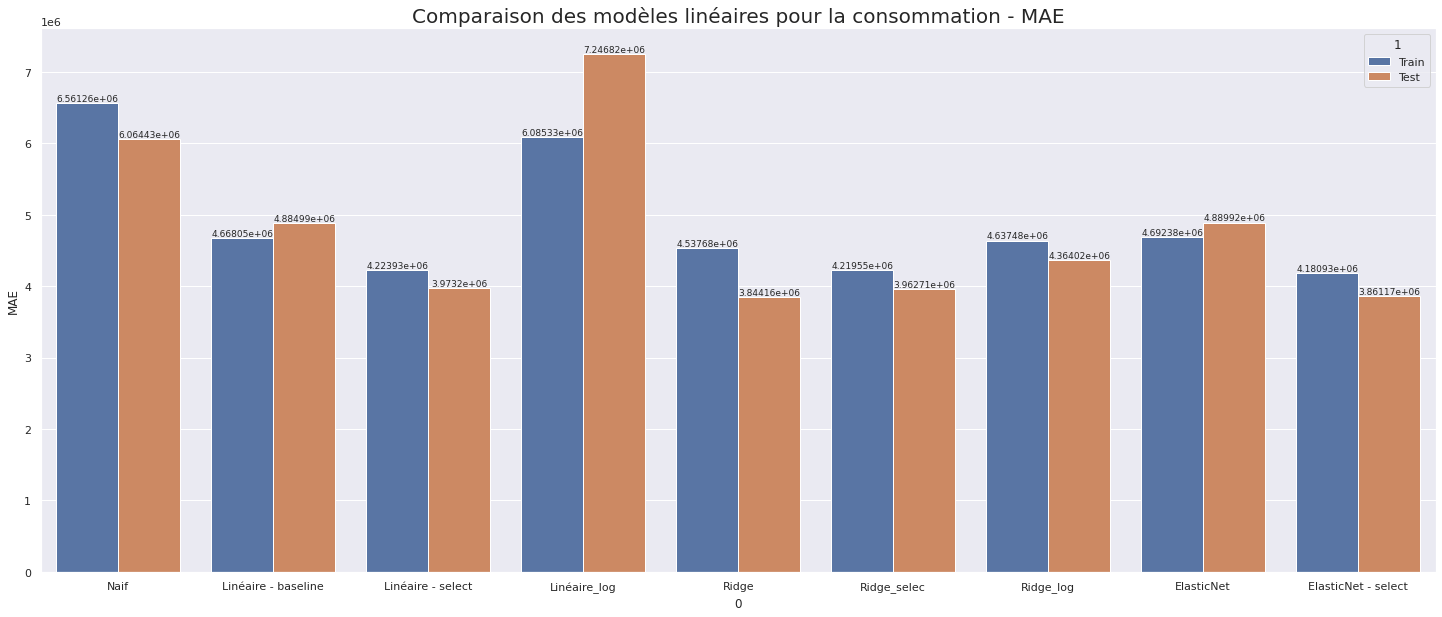

In [73]:
sns.set(font_scale = 0.5)
bilan_conso_MAE = bilan_conso_av_reg[bilan_conso_av_reg['2']=='MAE']

sns.set()
plt.rcParams["figure.figsize"] = (25,10)
ax = sns.barplot(x=bilan_conso_MAE['0'],y=abs(bilan_conso_MAE['3']),hue=bilan_conso_MAE['1'],data=bilan_conso_MAE)
_=ax.set_ylabel('MAE')
for container in ax.containers:
    ax.bar_label(container,fontsize=9)
_ = ax.set_title('Comparaison des modèles linéaires pour la consommation - MAE', fontsize=20)

## 4-2) Cas des émissions de CO2

In [74]:
# Affichage des scores - Emmissions

bilan_emmi_av_reg['3']=pd.to_numeric(bilan_emmi_av_reg['3'])
# bilan_emmi_av_reg['3'] = bilan_emmi_av_reg['3'].apply('{0:.2f}'.format)
bilan_emmi_av_reg.pivot(index='0',columns=['2','1']).sort_values([('3',  'MAE',  'Test')],ascending=True)

3                                          \
2                           MAE          RMSE            R2         MAE   
1                         Train         Train         Train        Test   
0                                                                         
Ridge_log            120.899918  3.197529e+05  1.563485e-01   99.243031   
Ridge_selec          121.227658  1.584479e+05  5.819433e-01   99.405557   
Ridge                125.673830  1.799039e+05  5.253327e-01  100.450337   
ElasticNet - select  133.379956  1.356327e+05  6.421400e-01  127.305700   
Linéaire_log         215.213473  5.666349e+06 -2.727040e+06  130.693245   
ElasticNet           140.555986  1.176811e+05  6.895045e-01  139.759914   
Linéaire - select    143.080825  1.239220e+05  6.730381e-01  141.011129   
Naif                 149.977890  3.076880e+05 -5.139258e-02  141.914862   
Linéaire - baseline  145.569196  1.148886e+05  6.968723e-01  152.520328   

                                              
2                             RMSE        R2  
1                             Test      Test  
0                                             
Ridge_log            118665.795656  0.282121  
Ridge_selec           46218.300350  0.520550  
Ridge                 39603.193532  0.589172  
ElasticNet - select   82032.745798  0.149025  
Linéaire_log         444012.882913 -3.606013  
ElasticNet            79765.578480  0.172544  
Linéaire - select     81693.660769  0.152543  
Naif                 454966.004977 -0.029148  
Linéaire - baseline   84170.662601  0.126847

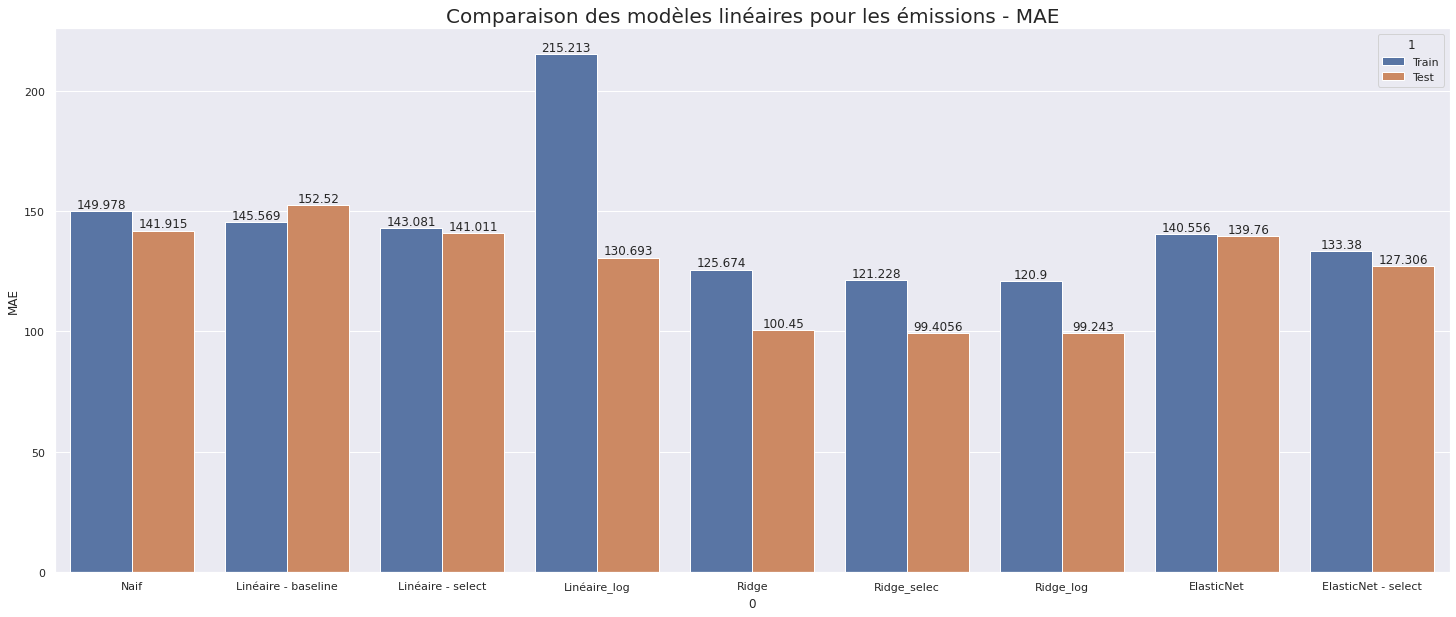

In [75]:
bilan_emmi_MAE = bilan_emmi_av_reg[bilan_emmi_av_reg['2']=='MAE']

sns.set()
plt.rcParams["figure.figsize"] = (25,10)
ax = sns.barplot(x=bilan_emmi_MAE['0'],y=abs(bilan_emmi_MAE['3']),hue=bilan_emmi_MAE['1'],data=bilan_emmi_MAE)
_=ax.set_ylabel('MAE')
for container in ax.containers:
    ax.bar_label(container)
_ = ax.set_title('Comparaison des modèles linéaires pour les émissions - MAE', fontsize=20)

## 5) Conclusion

### Test sur les années futures avec les meilleurs modèles

In [76]:
# Importation des années futures
data_encoded_2016_temp = data_encoded_2016.drop(['ENERGYSTARScore','TotalGHGEmissions','SiteEnergyUse'],axis=1)
data_encoded_futur_temp = data_encoded_futur.drop(['ENERGYSTARScore','TotalGHGEmissions','SiteEnergyUse'],axis=1)

### 5-1) Cas de la consommation

In [77]:
# Metrics sur 2016
predictions_conso_EN_selec_2016 = model_EN_conso_select.predict(data_encoded_2016_temp[features_a_conserver_conso])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(data_encoded_2016['SiteEnergyUse'], predictions_conso_EN_selec_2016)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(data_encoded_2016['SiteEnergyUse'], predictions_conso_EN_selec_2016)))
print("R2 : {:.2f}".format(r2_score(data_encoded_2016['SiteEnergyUse'],predictions_conso_EN_selec_2016)))

RMSE : 244269175805161.62
MAE : 4740978.18
R2 : 0.48


In [78]:
# Metrics sur les batiments jamais rencontrés
predictions_conso_futur=model_EN_conso_select.predict(data_encoded_futur_temp[features_a_conserver_conso])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(data_encoded_futur['SiteEnergyUse'], predictions_conso_futur)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(data_encoded_futur['SiteEnergyUse'], predictions_conso_futur)))
print("R2 : {:.2f}".format(r2_score(data_encoded_futur['SiteEnergyUse'],predictions_conso_futur)))

RMSE : 584150313040810.12
MAE : 13088772.18
R2 : 0.47


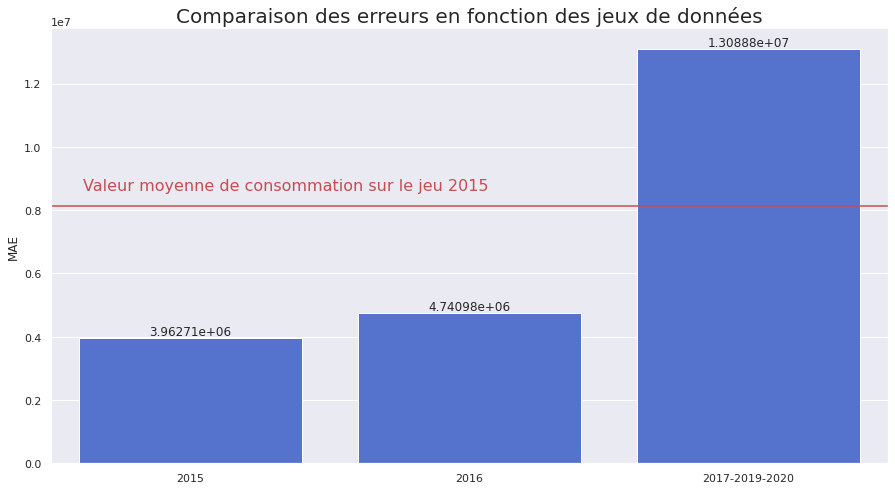

In [79]:
# Comparaison des erreurs de prédictions sur les jeux de données
sns.set()
plt.rcParams["figure.figsize"] = (15,8)
Jeux_de_données = ['2015','2016','2017-2019-2020']
Valeurs = [metrics.mean_absolute_error(target_conso_test, predictions_conso_selec_Ridge_test),metrics.mean_absolute_error(data_encoded_2016['SiteEnergyUse'], predictions_conso_EN_selec_2016),metrics.mean_absolute_error(data_encoded_futur['SiteEnergyUse'], predictions_conso_futur)]

ax = sns.barplot(x=Jeux_de_données,y=Valeurs,color='royalblue')
plt.axhline(y=8124608,color='r')
_=ax.set_ylabel('MAE')

ax.annotate('Valeur moyenne de consommation sur le jeu 2015', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-400, 270), textcoords='offset points',color='r',
                ha='right', va='bottom')

for container in ax.containers:
    ax.bar_label(container)

_ = ax.set_title('Comparaison des erreurs en fonction des jeux de données', fontsize=20)

Text(0.5, 1.0, 'Prédictions années futures')

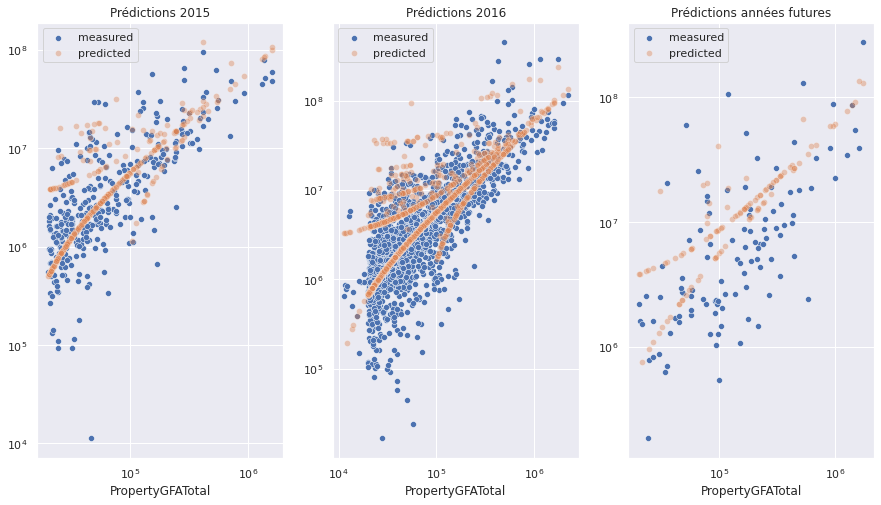

In [80]:
sns.set(font_scale = 1)
fig, axes = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (25,7)

# Sur le jeu de 2015
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_conso_selec_Ridge_test.ravel(), label='predicted', alpha=0.4,ax = axes[0])

# Sur le jeu de 2016
sns.scatterplot(x=data_encoded_2016['PropertyGFATotal'], y=data_encoded_2016['SiteEnergyUse'].values.ravel(), label='measured' ,ax = axes[1])
sns.scatterplot(x=data_encoded_2016['PropertyGFATotal'], y=predictions_conso_EN_selec_2016.ravel(), label='predicted', alpha=0.4,ax = axes[1])

# Sur les années futures
sns.scatterplot(x=data_encoded_futur['PropertyGFATotal'], y=data_encoded_futur['SiteEnergyUse'].values.ravel(), label='measured' ,ax = axes[2])
sns.scatterplot(x=data_encoded_futur['PropertyGFATotal'], y=predictions_conso_futur.ravel(), label='predicted', alpha=0.4,ax = axes[2])

for i in range(3):
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    
axes[0].set_title('Prédictions 2015')
axes[1].set_title('Prédictions 2016')
axes[2].set_title('Prédictions années futures')

### 5-2) Cas des émissions de CO2

In [81]:
# Metrics sur 2016
predictions_emmi_selec_Ridge_2016 = model_emmi_RS.predict(data_encoded_2016_temp[features_a_conserver_emmi])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(data_encoded_2016['TotalGHGEmissions'], predictions_emmi_selec_Ridge_2016)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(data_encoded_2016['TotalGHGEmissions'], predictions_emmi_selec_Ridge_2016)))
print("R2 : {:.2f}".format(r2_score(data_encoded_2016['TotalGHGEmissions'],predictions_emmi_selec_Ridge_2016)))

RMSE : 297049.96
MAE : 132.49
R2 : 0.40


In [82]:
# Metrics sur les batiments jamais rencontrés
predictions_emmi_selec_Ridge_futur = model_emmi_RS.predict(data_encoded_futur_temp[features_a_conserver_emmi])

print("RMSE : {:.2f}".format(metrics.mean_squared_error(data_encoded_futur['TotalGHGEmissions'], predictions_emmi_selec_Ridge_futur)))
print("MAE : {:.2f}".format(metrics.mean_absolute_error(data_encoded_futur['TotalGHGEmissions'], predictions_emmi_selec_Ridge_futur)))
print("R2 : {:.2f}".format(r2_score(data_encoded_futur['TotalGHGEmissions'],predictions_emmi_selec_Ridge_futur)))

RMSE : 1031606.11
MAE : 337.36
R2 : 0.30


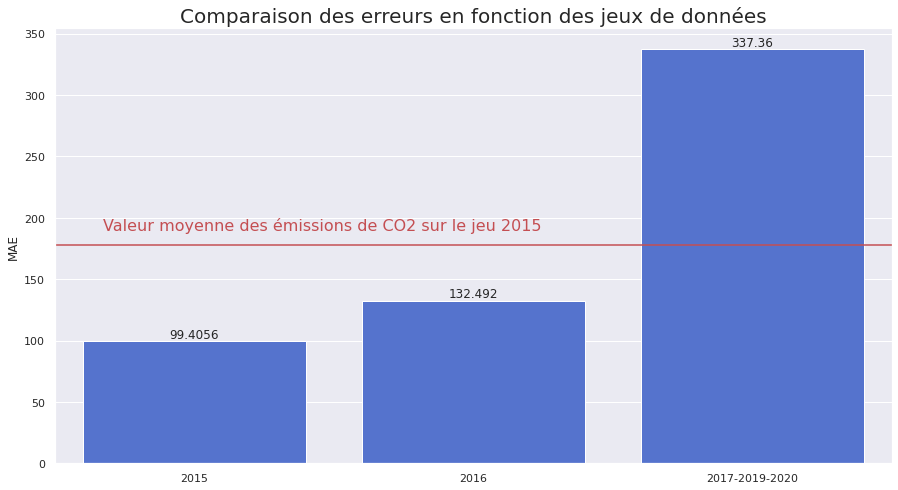

In [83]:
# Comparaison des erreurs de prédictions sur les jeux de données
sns.set()
plt.rcParams["figure.figsize"] = (15,8)
Jeux_de_données = ['2015','2016','2017-2019-2020']
Valeurs = [metrics.mean_absolute_error(target_emmi_test, predictions_emmi_selec_Ridge_test),metrics.mean_absolute_error(data_encoded_2016['TotalGHGEmissions'], predictions_emmi_selec_Ridge_2016),metrics.mean_absolute_error(data_encoded_futur['TotalGHGEmissions'], predictions_emmi_selec_Ridge_futur)]

ax = sns.barplot(x=Jeux_de_données,y=Valeurs,color='royalblue')
plt.axhline(y=178,color='r')

_=ax.set_ylabel('MAE')
ax.annotate('Valeur moyenne des émissions de CO2 sur le jeu 2015', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-350, 230), textcoords='offset points',color='r',
                ha='right', va='bottom')

for container in ax.containers:
    ax.bar_label(container)

_ = ax.set_title('Comparaison des erreurs en fonction des jeux de données', fontsize=20)

Text(0.5, 1.0, 'Prédictions années futures')

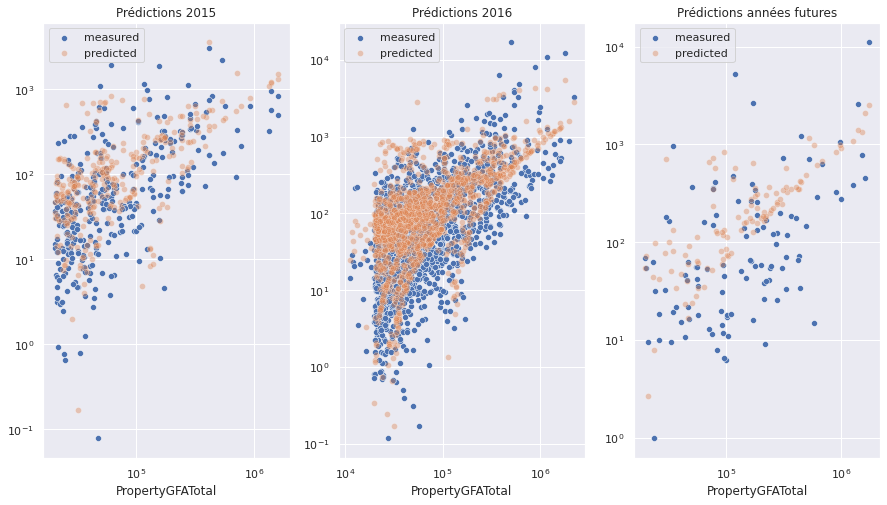

In [84]:
sns.set(font_scale = 1)
fig, axes = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (25,7)

# Sur le jeu de 2015
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_emmi_selec_Ridge_test.ravel(), label='predicted', alpha=0.4,ax = axes[0])

# Sur le jeu de 2016
sns.scatterplot(x=data_encoded_2016['PropertyGFATotal'], y=data_encoded_2016['TotalGHGEmissions'].values.ravel(), label='measured' ,ax = axes[1])
sns.scatterplot(x=data_encoded_2016['PropertyGFATotal'], y=predictions_emmi_selec_Ridge_2016.ravel(), label='predicted', alpha=0.4,ax = axes[1])

# Sur les années futures
sns.scatterplot(x=data_encoded_futur['PropertyGFATotal'], y=data_encoded_futur['TotalGHGEmissions'].values.ravel(), label='measured' ,ax = axes[2])
sns.scatterplot(x=data_encoded_futur['PropertyGFATotal'], y=predictions_emmi_selec_Ridge_futur.ravel(), label='predicted', alpha=0.4,ax = axes[2])

for i in range(3):
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    
axes[0].set_title('Prédictions 2015')
axes[1].set_title('Prédictions 2016')
axes[2].set_title('Prédictions années futures')

### 5-3) Affichage des prédictions des modèles

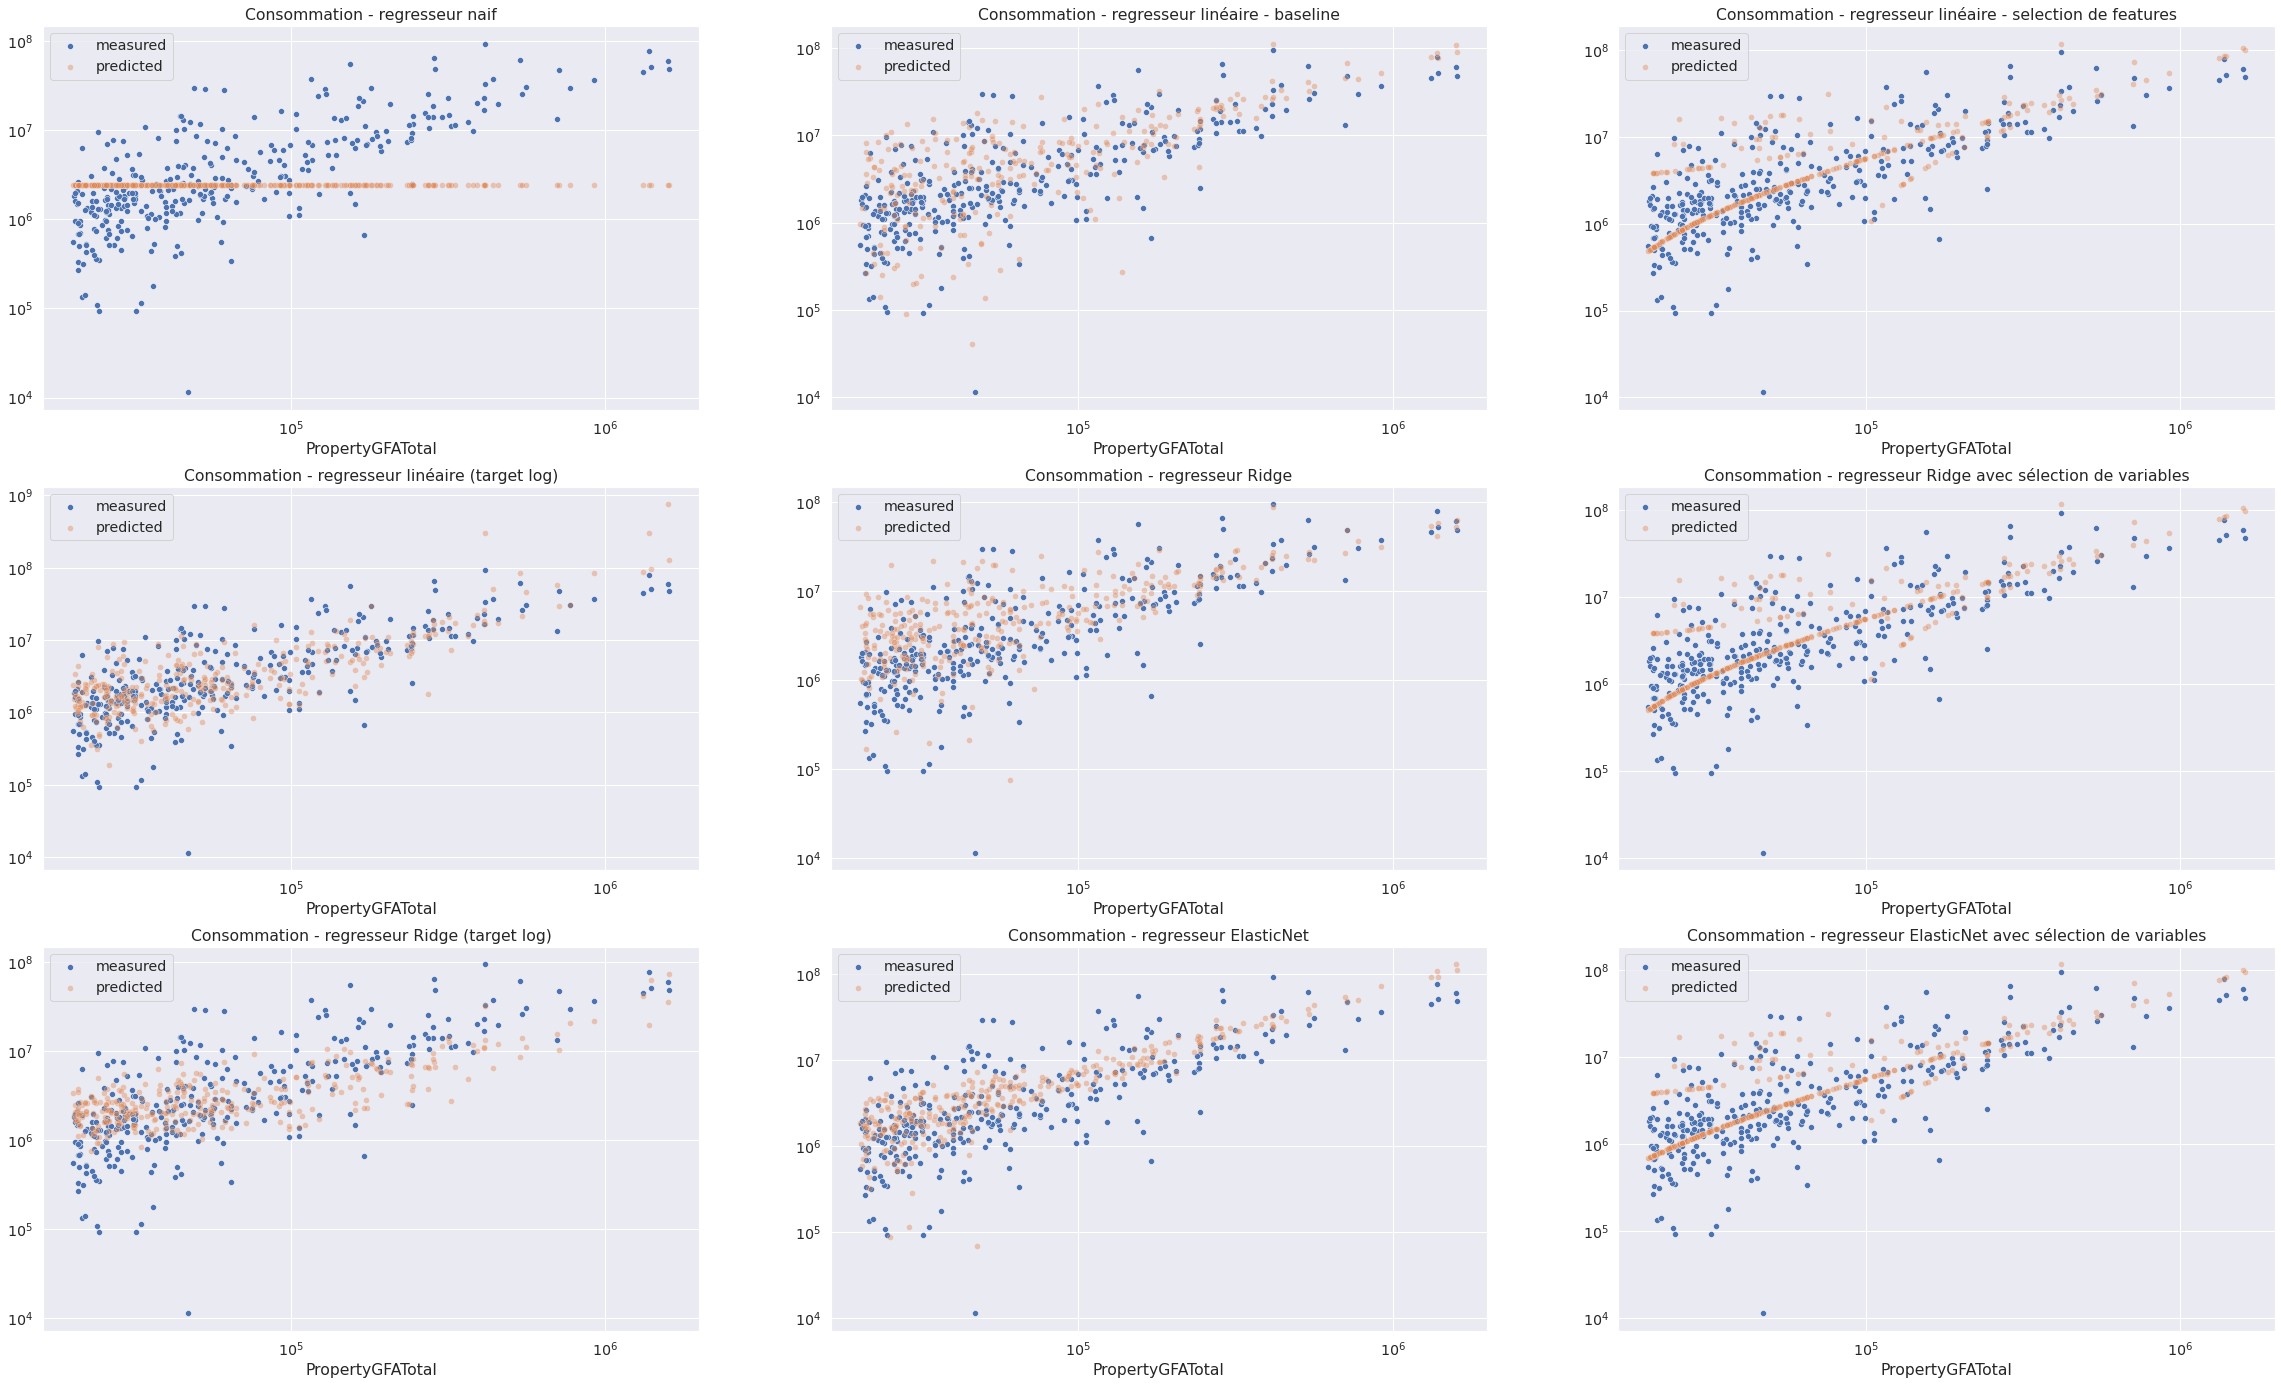

In [88]:
# Bilan modèles linéaires - consommation
sns.set(font_scale = 1.3)
fig, axes = plt.subplots(3,3)
plt.rcParams["figure.figsize"] = (40,24)

# Plot regresseur Linéaire - log
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[1,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=np.expm1(predictions_bilan_av_reg['y_pred_conso_log_lin'].ravel()), label='predicted', alpha=0.4,ax = axes[1,0])

# Plot regresseur Naif
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[0,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_dummy_conso'].ravel(), label='predicted', alpha=0.4,ax = axes[0,0])

# Plot regresseur Linéaire
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[0,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_conso_lin'].ravel(), label='predicted', alpha=0.4,ax = axes[0,1])

# Plot regresseur ElasticNet avec sélection de variables
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[2,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_conso_select_eNet'].ravel(), label='predicted', alpha=0.4,ax = axes[2,2])

# Plot regresseur ElasticNet
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[2,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_conso_eNet'].ravel(), label='predicted', alpha=0.4,ax = axes[2,1])

# Plot regresseur Linéaire - sélection de features
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[0,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_conso_select_lin'].ravel(), label='predicted', alpha=0.4,ax = axes[0,2])

# Plot regresseur Ridge
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[1,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_conso_Ridge'].ravel(), label='predicted', alpha=0.4,ax = axes[1,1])

# Plot regresseur Ridge avec sélection de variables
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[1,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_conso_selec_Ridge'].ravel(), label='predicted', alpha=0.4,ax = axes[1,2])

# Plot regresseur Ridge - log
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_conso_test.values.ravel(), label='measured' ,ax = axes[2,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=np.expm1(predictions_conso_log_Ridge_test.ravel()), label='predicted', alpha=0.4,ax = axes[2,0])


# Mise en place des titres et de l'échelle des axes
axes[0,0].set_title('Consommation - regresseur naif')
axes[0,1].set_title('Consommation - regresseur linéaire - baseline')
axes[0,2].set_title('Consommation - regresseur linéaire - selection de features')
axes[1,0].set_title('Consommation - regresseur linéaire (target log)')
axes[1,1].set_title('Consommation - regresseur Ridge')
axes[1,2].set_title('Consommation - regresseur Ridge avec sélection de variables')
axes[2,0].set_title('Consommation - regresseur Ridge (target log)')
axes[2,1].set_title('Consommation - regresseur ElasticNet')
axes[2,2].set_title('Consommation - regresseur ElasticNet avec sélection de variables')


for i in range(3):
    for j in range(3):
        axes[i,j].set_yscale('log')
        axes[i,j].set_xscale('log')


# _=plt.suptitle('Analyse des prédictions des modèles', fontsize=22)

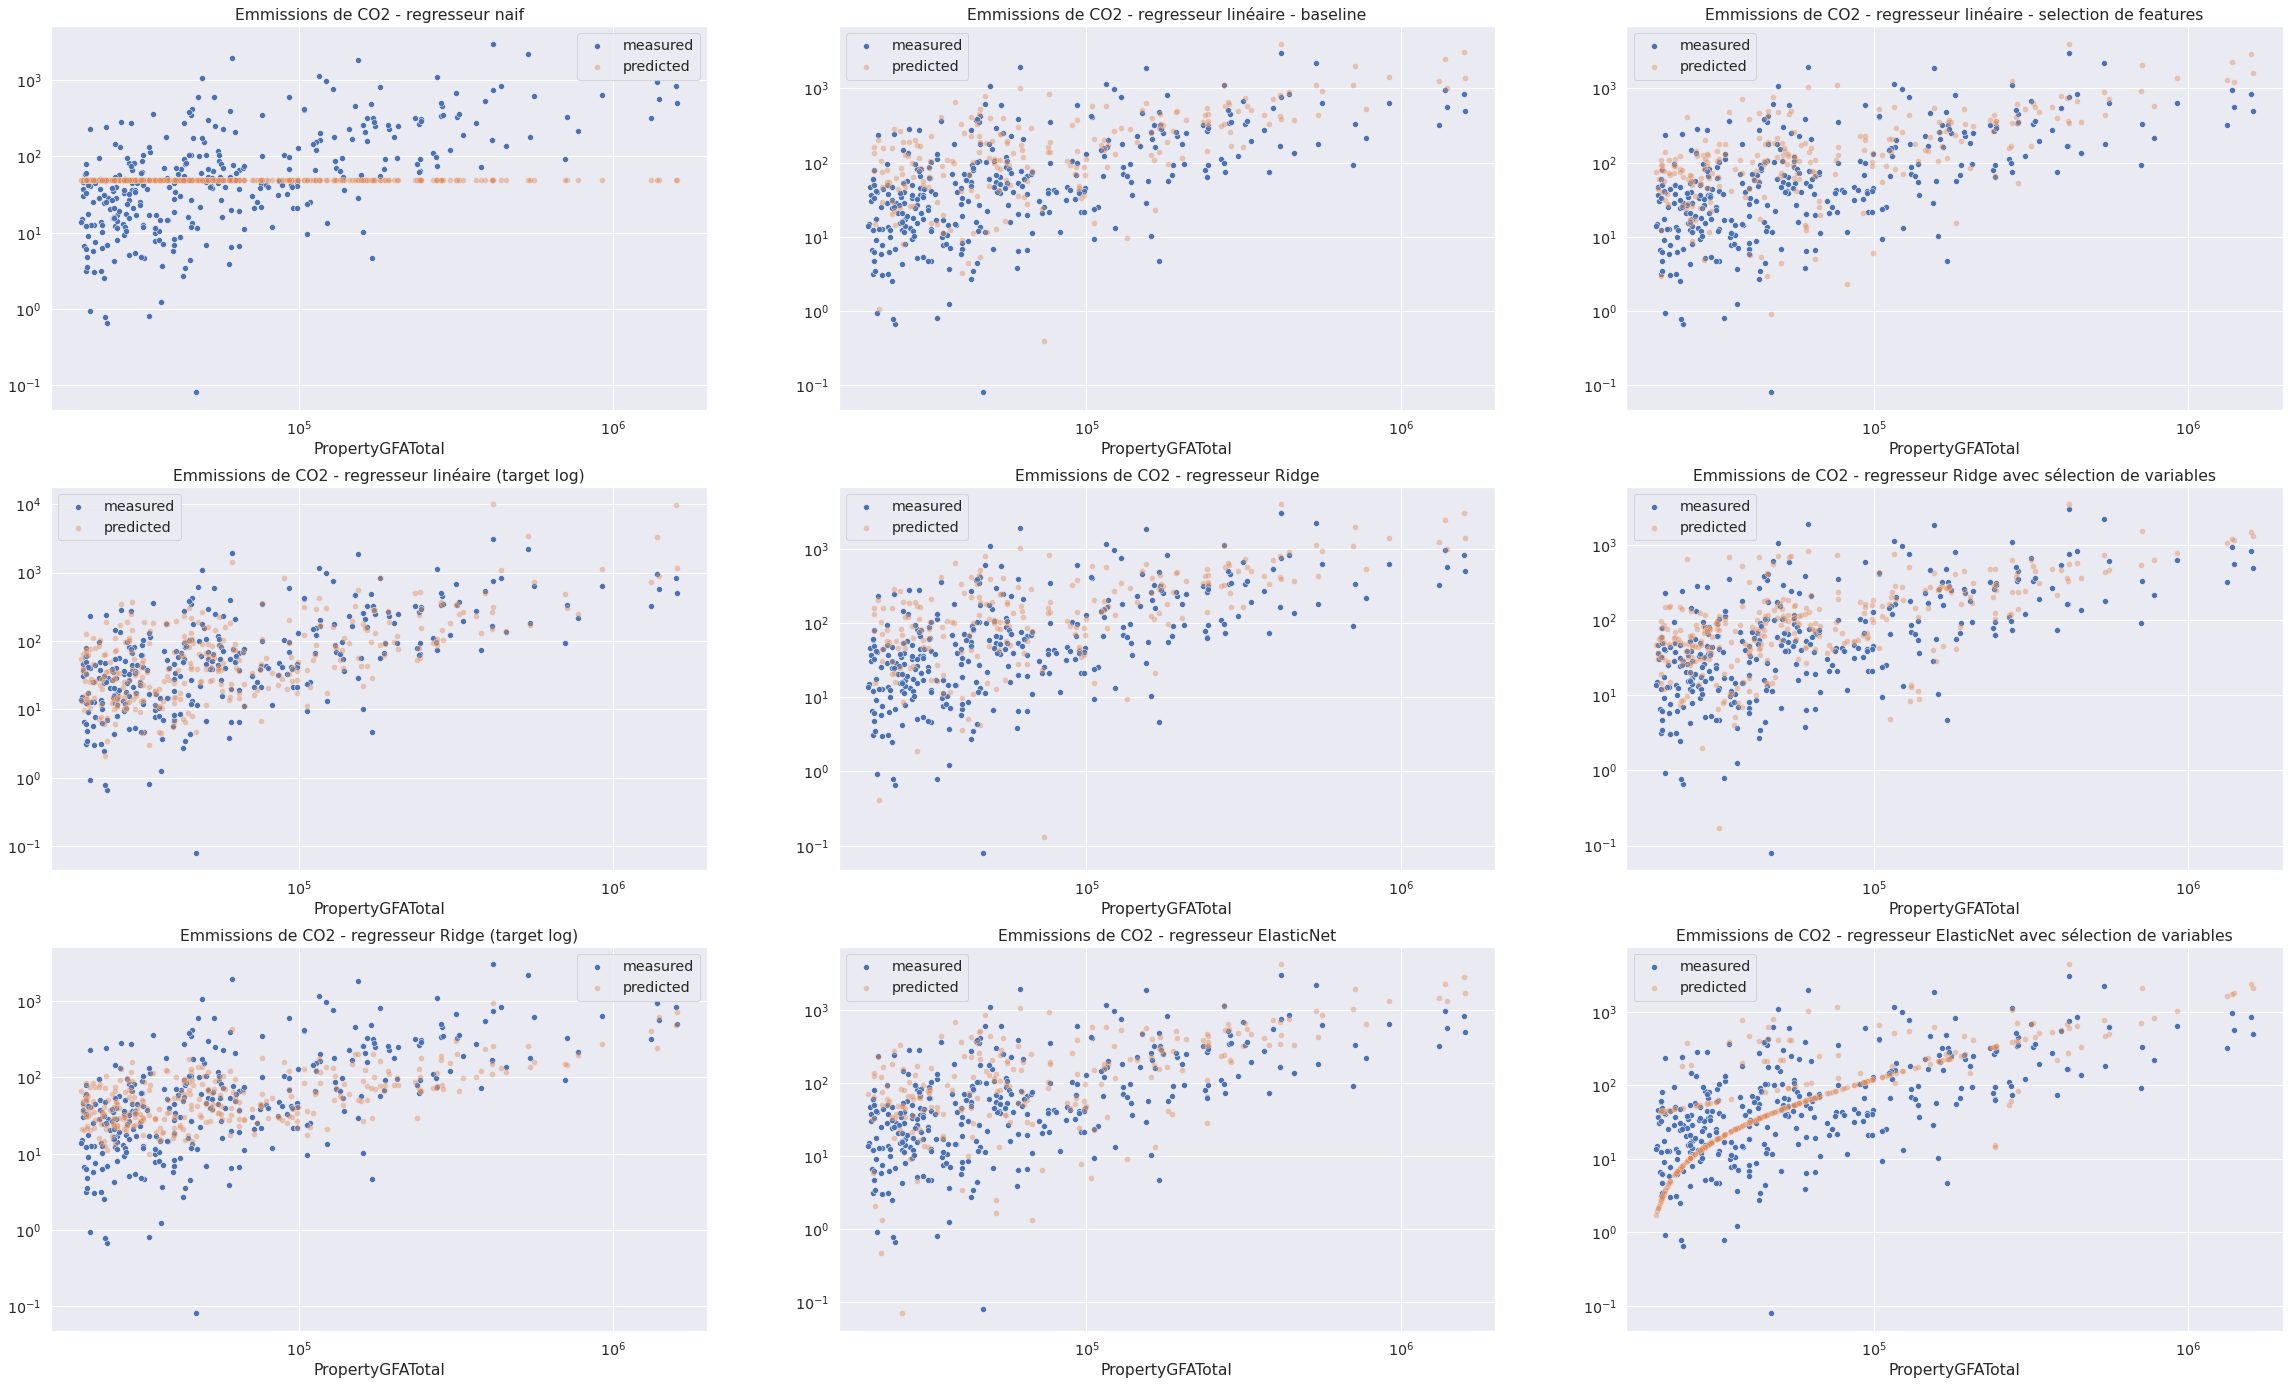

In [86]:
# Bilan modèles linéaires - emmissions
sns.set(font_scale = 1.3)
fig, axes = plt.subplots(3,3)
plt.rcParams["figure.figsize"] = (40,24)

# Plot regresseur Linéaire - log
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[1,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=np.expm1(predictions_bilan_av_reg['y_pred_emmi_log_lin'].ravel()), label='predicted', alpha=0.4,ax = axes[1,0])

# Plot regresseur Naif
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[0,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_dummy_emmi'].ravel(), label='predicted', alpha=0.4,ax = axes[0,0])

# Plot regresseur Linéaire
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[0,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_emmi_lin'].ravel(), label='predicted', alpha=0.4,ax = axes[0,1])

# Plot regresseur ElasticNet avec sélection de variables
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[2,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_emmi_select_eNet'].ravel(), label='predicted', alpha=0.4,ax = axes[2,2])

# Plot regresseur ElasticNet
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[2,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_emmi_eNet'].ravel(), label='predicted', alpha=0.4,ax = axes[2,1])

# Plot regresseur Linéaire - sélection de features
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[0,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['y_pred_emmi_select_lin'].ravel(), label='predicted', alpha=0.4,ax = axes[0,2])

# Plot regresseur Ridge
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[1,1])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_emmi_ridge'].ravel(), label='predicted', alpha=0.4,ax = axes[1,1])

# Plot regresseur Ridge avec sélection de variables
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[1,2])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=predictions_bilan_av_reg['predictions_emmi_selec_Ridge'].ravel(), label='predicted', alpha=0.4,ax = axes[1,2])

# Plot regresseur Ridge - log
sns.scatterplot(x=data_test['PropertyGFATotal'], y=target_emmi_test.values.ravel(), label='measured' ,ax = axes[2,0])
sns.scatterplot(x=data_test['PropertyGFATotal'], y=np.expm1(predictions_emmi_log_Ridge_test.ravel()), label='predicted', alpha=0.4,ax = axes[2,0])


# Mise en place des titres et de l'échelle des axes
axes[0,0].set_title('Emmissions de CO2 - regresseur naif')
axes[0,1].set_title('Emmissions de CO2 - regresseur linéaire - baseline')
axes[0,2].set_title('Emmissions de CO2 - regresseur linéaire - selection de features')
axes[1,0].set_title('Emmissions de CO2 - regresseur linéaire (target log)')
axes[1,1].set_title('Emmissions de CO2 - regresseur Ridge')
axes[1,2].set_title('Emmissions de CO2 - regresseur Ridge avec sélection de variables')
axes[2,0].set_title('Emmissions de CO2 - regresseur Ridge (target log)')
axes[2,1].set_title('Emmissions de CO2 - regresseur ElasticNet')
axes[2,2].set_title('Emmissions de CO2 - regresseur ElasticNet avec sélection de variables')


for i in range(3):
    for j in range(3):
        axes[i,j].set_yscale('log')
        axes[i,j].set_xscale('log')


# _=plt.suptitle('Analyse des prédictions des modèles', fontsize=22)

In [87]:
# Exportation
predictions_bilan_av_reg.to_csv('predictions_bilan_av_reg.csv')
bilan_conso_av_reg.to_csv("bilan_conso_av_reg.csv")
bilan_emmi_av_reg.to_csv("bilan_emmi_av_reg.csv")